In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from cfg import config
import pickle

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/instruments.csv') # Read in our CSV file
df.set_index('fname', inplace=True) # Set the fname collumn as our index

for f in df.index:
    rate, signal = wavfile.read('data/clean/'+f) # Grab rate and signal from each file
    df.at[f,'length'] = signal.shape[0] / rate # Set the length of each file based on signal and rate

classes = list(np.unique(df.label)) # Grab classes
class_dist = df.groupby(['label'])['length'].mean() # create a distribution of the classes based on the mean number of each

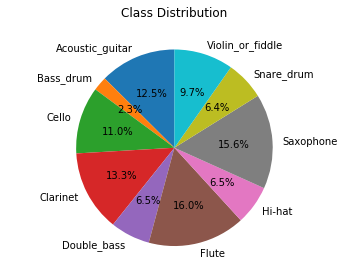

In [3]:
# Plot class distribution
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [4]:
n_samples = 2 * int(df['length'].sum() / 0.1) # Set number of samples to be 20% of the length in time of all data
prob_dist = class_dist / class_dist.sum() # Convert to range of [0,1]
choices = np.random.choice(class_dist.index, p=prob_dist) # Choose a class

In [5]:
config = config(mode='conv')

In [6]:
def check_data():
    # If there is data, load it in 
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [18]:
def build_rand_feat():
    """
    This function creates a randomly generated and normalized 4-D feature vector
    """
    tmp = check_data() # Load in old pickle data if it exists
    if tmp:
        print(config.mode)
        print(config.p_path)
        return tmp.data[0], tmp.data[1] # Returns our previously built randomized feature
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist) # Pick a random class based on our prob_dist probabilities
        file = np.random.choice(df[df.label==rand_class].index) # Choose a random file of class rand_class and get its index
        rate, wav = wavfile.read('data/clean/'+file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0, wav.shape[0] - config.step) # Go to random time point in audio file
        sample = wav[rand_index:rand_index + config.step] # Grab a portion of our wav file at rand_index time point
        X_sample = mfcc(sample, rate,
                       numcep=config.nfeat, nfilt=config.nfilt, nfft = config.nfft)
        _min = min(np.amin(X_sample), _min) # Update min if our sample min is smaller
        _max = max(np.amax(X_sample), _max) # Update max if our sample max is larger
        X.append(X_sample) # Add our randomly selected sample to list X
        y.append(classes.index(label)) # Add the index corrosponding to our sample's label to list y
    config.min = _min # Save min
    config.max = _max # Save max
    X, y = np.array(X), np.array(y) 
    X = (X - _min) / (_max - _min) # Normalize our input matrix X based on min and range, possible to normalize based on mean and standard deviation as well
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode=='time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes = 10)
    config.data = (X, y) # Store the data
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
        
    return X, y
        

In [8]:
def get_conv_model():
    model = Sequential()
    # Note that we only use a tenth of a second of our data, so we don't want to pool too much
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), # Strides only (1,1) due to small input space
                    padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), 
                    padding='same'))
    model.add(MaxPool2D((2,2), dim_ordering="th"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax')) # Final layer activate with softmax due to our categorical cross-entropy method
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [9]:
def get_recurrent_model():
    # Shape of data for RNN is (n,time,feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [10]:
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) # Flatten out by grabbing collumn corrosponding to y label
    input_shape = (X.shape[1], X.shape[2], 1) # Grab input shape not including number of samples (since each input is one sample)
    model = get_conv_model()
elif config.mode == 'time':
    X, y = build_rand_feat()
    """
    TODO
    
    our rand_feat is saved as a pickle file and needs to be reshaped if
    it was originally made for conv model (similar if running conv and 
    need to work with time)
    """
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y_flat = np.argmax(y, axis=1) # Flatten out by grabbing collumn corrosponding to y label
    input_shape = (X.shape[1], X.shape[2]) # Grab input shape not including number of samples (since each input is one sample)
    model = get_recurrent_model()
    
# Setup weights so that our gradient updates based on our class distribution 
# (less bass drumbs => stronger gradient from these samples)
# This will give a little extra accuracy as well as reducing bias
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                            save_best_only=True, save_weights_only=False, period=1)

# Fit our model
model.fit(X, y, epochs=10, 
         shuffle=True,
         class_weight=class_weight,
         validation_split=0.1,
         callbacks=[checkpoint])

model.save(config.model_path)


Loading existing data for conv model


c:\users\tsb\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)             

 6816/23769 [=======>......................] - ETA: 7:34 - loss: 2.3062 - acc: 0.062 - ETA: 4:16 - loss: 2.3044 - acc: 0.156 - ETA: 3:08 - loss: 2.3021 - acc: 0.187 - ETA: 2:33 - loss: 2.3061 - acc: 0.148 - ETA: 2:13 - loss: 2.3005 - acc: 0.162 - ETA: 1:59 - loss: 2.2983 - acc: 0.156 - ETA: 1:49 - loss: 2.2950 - acc: 0.147 - ETA: 1:42 - loss: 2.2934 - acc: 0.144 - ETA: 1:36 - loss: 2.2928 - acc: 0.152 - ETA: 1:31 - loss: 2.2986 - acc: 0.143 - ETA: 1:27 - loss: 2.3020 - acc: 0.147 - ETA: 1:23 - loss: 2.3048 - acc: 0.143 - ETA: 1:21 - loss: 2.3042 - acc: 0.139 - ETA: 1:18 - loss: 2.3036 - acc: 0.136 - ETA: 1:16 - loss: 2.3026 - acc: 0.139 - ETA: 1:15 - loss: 2.3015 - acc: 0.138 - ETA: 1:13 - loss: 2.3014 - acc: 0.136 - ETA: 1:12 - loss: 2.3006 - acc: 0.135 - ETA: 1:10 - loss: 2.3003 - acc: 0.138 - ETA: 1:09 - loss: 2.3006 - acc: 0.137 - ETA: 1:08 - loss: 2.2998 - acc: 0.139 - ETA: 1:07 - loss: 2.2990 - acc: 0.142 - ETA: 1:06 - loss: 2.2987 - acc: 0.139 - ETA: 1:05 - loss: 2.2985 - acc: 0

13696/23769 [================>.............] - ETA: 38s - loss: 1.7848 - acc: 0.35 - ETA: 38s - loss: 1.7831 - acc: 0.35 - ETA: 38s - loss: 1.7813 - acc: 0.35 - ETA: 38s - loss: 1.7782 - acc: 0.35 - ETA: 38s - loss: 1.7764 - acc: 0.35 - ETA: 38s - loss: 1.7732 - acc: 0.35 - ETA: 38s - loss: 1.7694 - acc: 0.36 - ETA: 38s - loss: 1.7674 - acc: 0.36 - ETA: 38s - loss: 1.7646 - acc: 0.36 - ETA: 38s - loss: 1.7635 - acc: 0.36 - ETA: 38s - loss: 1.7610 - acc: 0.36 - ETA: 38s - loss: 1.7575 - acc: 0.36 - ETA: 38s - loss: 1.7543 - acc: 0.36 - ETA: 38s - loss: 1.7517 - acc: 0.36 - ETA: 37s - loss: 1.7491 - acc: 0.36 - ETA: 37s - loss: 1.7455 - acc: 0.36 - ETA: 37s - loss: 1.7430 - acc: 0.36 - ETA: 37s - loss: 1.7430 - acc: 0.36 - ETA: 37s - loss: 1.7385 - acc: 0.37 - ETA: 37s - loss: 1.7355 - acc: 0.37 - ETA: 37s - loss: 1.7348 - acc: 0.37 - ETA: 37s - loss: 1.7334 - acc: 0.37 - ETA: 37s - loss: 1.7310 - acc: 0.37 - ETA: 37s - loss: 1.7290 - acc: 0.37 - ETA: 37s - loss: 1.7265 - acc: 0.37 - ETA

20576/23769 [========================>.....] - ETA: 23s - loss: 1.4445 - acc: 0.48 - ETA: 23s - loss: 1.4435 - acc: 0.48 - ETA: 23s - loss: 1.4423 - acc: 0.48 - ETA: 23s - loss: 1.4414 - acc: 0.48 - ETA: 23s - loss: 1.4409 - acc: 0.48 - ETA: 22s - loss: 1.4401 - acc: 0.48 - ETA: 22s - loss: 1.4390 - acc: 0.48 - ETA: 22s - loss: 1.4371 - acc: 0.48 - ETA: 22s - loss: 1.4367 - acc: 0.48 - ETA: 22s - loss: 1.4348 - acc: 0.48 - ETA: 22s - loss: 1.4335 - acc: 0.48 - ETA: 22s - loss: 1.4331 - acc: 0.48 - ETA: 22s - loss: 1.4317 - acc: 0.48 - ETA: 22s - loss: 1.4309 - acc: 0.48 - ETA: 22s - loss: 1.4299 - acc: 0.48 - ETA: 22s - loss: 1.4288 - acc: 0.48 - ETA: 22s - loss: 1.4277 - acc: 0.48 - ETA: 22s - loss: 1.4258 - acc: 0.48 - ETA: 21s - loss: 1.4245 - acc: 0.48 - ETA: 21s - loss: 1.4241 - acc: 0.49 - ETA: 21s - loss: 1.4236 - acc: 0.48 - ETA: 21s - loss: 1.4222 - acc: 0.49 - ETA: 21s - loss: 1.4209 - acc: 0.49 - ETA: 21s - loss: 1.4202 - acc: 0.49 - ETA: 21s - loss: 1.4186 - acc: 0.49 - ETA

23769/23769 [==============================] - ETA: 7s - loss: 1.2413 - acc: 0.557 - ETA: 7s - loss: 1.2399 - acc: 0.557 - ETA: 7s - loss: 1.2400 - acc: 0.557 - ETA: 6s - loss: 1.2398 - acc: 0.558 - ETA: 6s - loss: 1.2391 - acc: 0.558 - ETA: 6s - loss: 1.2384 - acc: 0.558 - ETA: 6s - loss: 1.2378 - acc: 0.558 - ETA: 6s - loss: 1.2372 - acc: 0.558 - ETA: 6s - loss: 1.2365 - acc: 0.559 - ETA: 6s - loss: 1.2355 - acc: 0.559 - ETA: 6s - loss: 1.2346 - acc: 0.559 - ETA: 6s - loss: 1.2345 - acc: 0.559 - ETA: 6s - loss: 1.2335 - acc: 0.560 - ETA: 6s - loss: 1.2328 - acc: 0.560 - ETA: 6s - loss: 1.2321 - acc: 0.560 - ETA: 6s - loss: 1.2314 - acc: 0.560 - ETA: 6s - loss: 1.2311 - acc: 0.560 - ETA: 5s - loss: 1.2302 - acc: 0.561 - ETA: 5s - loss: 1.2301 - acc: 0.561 - ETA: 5s - loss: 1.2297 - acc: 0.561 - ETA: 5s - loss: 1.2291 - acc: 0.561 - ETA: 5s - loss: 1.2285 - acc: 0.561 - ETA: 5s - loss: 1.2276 - acc: 0.562 - ETA: 5s - loss: 1.2270 - acc: 0.562 - ETA: 5s - loss: 1.2261 - acc: 0.562 - ETA

 6880/23769 [=======>......................] - ETA: 54s - loss: 0.7151 - acc: 0.68 - ETA: 56s - loss: 0.7124 - acc: 0.68 - ETA: 55s - loss: 0.7980 - acc: 0.69 - ETA: 55s - loss: 0.7452 - acc: 0.71 - ETA: 54s - loss: 0.6816 - acc: 0.74 - ETA: 53s - loss: 0.6548 - acc: 0.75 - ETA: 53s - loss: 0.6893 - acc: 0.75 - ETA: 53s - loss: 0.6709 - acc: 0.75 - ETA: 53s - loss: 0.6544 - acc: 0.77 - ETA: 52s - loss: 0.6907 - acc: 0.75 - ETA: 52s - loss: 0.7004 - acc: 0.75 - ETA: 52s - loss: 0.7199 - acc: 0.75 - ETA: 52s - loss: 0.7466 - acc: 0.74 - ETA: 52s - loss: 0.7458 - acc: 0.74 - ETA: 52s - loss: 0.7409 - acc: 0.74 - ETA: 52s - loss: 0.7365 - acc: 0.74 - ETA: 52s - loss: 0.7262 - acc: 0.74 - ETA: 52s - loss: 0.7268 - acc: 0.74 - ETA: 52s - loss: 0.7236 - acc: 0.74 - ETA: 52s - loss: 0.7231 - acc: 0.74 - ETA: 52s - loss: 0.7129 - acc: 0.75 - ETA: 52s - loss: 0.7067 - acc: 0.75 - ETA: 51s - loss: 0.6976 - acc: 0.75 - ETA: 52s - loss: 0.7149 - acc: 0.75 - ETA: 52s - loss: 0.7024 - acc: 0.75 - ETA

13760/23769 [================>.............] - ETA: 37s - loss: 0.6571 - acc: 0.77 - ETA: 37s - loss: 0.6579 - acc: 0.77 - ETA: 37s - loss: 0.6581 - acc: 0.77 - ETA: 37s - loss: 0.6596 - acc: 0.77 - ETA: 37s - loss: 0.6584 - acc: 0.77 - ETA: 37s - loss: 0.6592 - acc: 0.76 - ETA: 37s - loss: 0.6589 - acc: 0.77 - ETA: 37s - loss: 0.6623 - acc: 0.76 - ETA: 37s - loss: 0.6615 - acc: 0.77 - ETA: 37s - loss: 0.6603 - acc: 0.77 - ETA: 37s - loss: 0.6609 - acc: 0.77 - ETA: 37s - loss: 0.6606 - acc: 0.77 - ETA: 37s - loss: 0.6621 - acc: 0.77 - ETA: 37s - loss: 0.6632 - acc: 0.76 - ETA: 36s - loss: 0.6636 - acc: 0.76 - ETA: 36s - loss: 0.6634 - acc: 0.76 - ETA: 36s - loss: 0.6634 - acc: 0.76 - ETA: 36s - loss: 0.6636 - acc: 0.76 - ETA: 36s - loss: 0.6646 - acc: 0.76 - ETA: 36s - loss: 0.6641 - acc: 0.76 - ETA: 36s - loss: 0.6631 - acc: 0.77 - ETA: 36s - loss: 0.6624 - acc: 0.77 - ETA: 36s - loss: 0.6628 - acc: 0.77 - ETA: 36s - loss: 0.6630 - acc: 0.77 - ETA: 36s - loss: 0.6625 - acc: 0.77 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.6180 - acc: 0.78 - ETA: 22s - loss: 0.6180 - acc: 0.78 - ETA: 22s - loss: 0.6181 - acc: 0.78 - ETA: 22s - loss: 0.6182 - acc: 0.78 - ETA: 21s - loss: 0.6184 - acc: 0.78 - ETA: 21s - loss: 0.6186 - acc: 0.78 - ETA: 21s - loss: 0.6187 - acc: 0.78 - ETA: 21s - loss: 0.6188 - acc: 0.78 - ETA: 21s - loss: 0.6191 - acc: 0.78 - ETA: 21s - loss: 0.6189 - acc: 0.78 - ETA: 21s - loss: 0.6187 - acc: 0.78 - ETA: 21s - loss: 0.6192 - acc: 0.78 - ETA: 21s - loss: 0.6192 - acc: 0.78 - ETA: 21s - loss: 0.6187 - acc: 0.78 - ETA: 21s - loss: 0.6183 - acc: 0.78 - ETA: 21s - loss: 0.6180 - acc: 0.78 - ETA: 21s - loss: 0.6172 - acc: 0.78 - ETA: 20s - loss: 0.6170 - acc: 0.78 - ETA: 20s - loss: 0.6172 - acc: 0.78 - ETA: 20s - loss: 0.6171 - acc: 0.78 - ETA: 20s - loss: 0.6166 - acc: 0.78 - ETA: 20s - loss: 0.6163 - acc: 0.78 - ETA: 20s - loss: 0.6162 - acc: 0.78 - ETA: 20s - loss: 0.6158 - acc: 0.78 - ETA: 20s - loss: 0.6158 - acc: 0.78 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.5853 - acc: 0.797 - ETA: 6s - loss: 0.5848 - acc: 0.797 - ETA: 6s - loss: 0.5848 - acc: 0.797 - ETA: 6s - loss: 0.5844 - acc: 0.797 - ETA: 6s - loss: 0.5845 - acc: 0.797 - ETA: 6s - loss: 0.5841 - acc: 0.797 - ETA: 6s - loss: 0.5841 - acc: 0.797 - ETA: 6s - loss: 0.5839 - acc: 0.797 - ETA: 6s - loss: 0.5839 - acc: 0.797 - ETA: 6s - loss: 0.5839 - acc: 0.797 - ETA: 6s - loss: 0.5839 - acc: 0.797 - ETA: 6s - loss: 0.5837 - acc: 0.797 - ETA: 6s - loss: 0.5833 - acc: 0.798 - ETA: 5s - loss: 0.5835 - acc: 0.797 - ETA: 5s - loss: 0.5833 - acc: 0.797 - ETA: 5s - loss: 0.5828 - acc: 0.798 - ETA: 5s - loss: 0.5829 - acc: 0.798 - ETA: 5s - loss: 0.5831 - acc: 0.797 - ETA: 5s - loss: 0.5831 - acc: 0.797 - ETA: 5s - loss: 0.5829 - acc: 0.797 - ETA: 5s - loss: 0.5827 - acc: 0.798 - ETA: 5s - loss: 0.5825 - acc: 0.798 - ETA: 5s - loss: 0.5819 - acc: 0.798 - ETA: 5s - loss: 0.5814 - acc: 0.798 - ETA: 5s - loss: 0.5813 - acc: 0.798 - ETA

 6880/23769 [=======>......................] - ETA: 55s - loss: 0.7714 - acc: 0.68 - ETA: 55s - loss: 0.6365 - acc: 0.73 - ETA: 53s - loss: 0.5790 - acc: 0.79 - ETA: 52s - loss: 0.5772 - acc: 0.78 - ETA: 52s - loss: 0.5913 - acc: 0.78 - ETA: 51s - loss: 0.5974 - acc: 0.78 - ETA: 51s - loss: 0.5758 - acc: 0.78 - ETA: 51s - loss: 0.5670 - acc: 0.78 - ETA: 50s - loss: 0.5647 - acc: 0.79 - ETA: 50s - loss: 0.5483 - acc: 0.80 - ETA: 50s - loss: 0.5320 - acc: 0.81 - ETA: 50s - loss: 0.5351 - acc: 0.81 - ETA: 49s - loss: 0.5470 - acc: 0.81 - ETA: 49s - loss: 0.5389 - acc: 0.81 - ETA: 49s - loss: 0.5505 - acc: 0.81 - ETA: 49s - loss: 0.5456 - acc: 0.81 - ETA: 49s - loss: 0.5291 - acc: 0.81 - ETA: 49s - loss: 0.5160 - acc: 0.82 - ETA: 49s - loss: 0.5177 - acc: 0.82 - ETA: 49s - loss: 0.5222 - acc: 0.82 - ETA: 49s - loss: 0.5094 - acc: 0.82 - ETA: 49s - loss: 0.5005 - acc: 0.82 - ETA: 49s - loss: 0.5080 - acc: 0.82 - ETA: 49s - loss: 0.5011 - acc: 0.82 - ETA: 49s - loss: 0.4952 - acc: 0.83 - ETA

13760/23769 [================>.............] - ETA: 36s - loss: 0.4487 - acc: 0.84 - ETA: 36s - loss: 0.4487 - acc: 0.84 - ETA: 36s - loss: 0.4487 - acc: 0.84 - ETA: 36s - loss: 0.4485 - acc: 0.84 - ETA: 36s - loss: 0.4483 - acc: 0.84 - ETA: 36s - loss: 0.4475 - acc: 0.84 - ETA: 36s - loss: 0.4468 - acc: 0.84 - ETA: 35s - loss: 0.4480 - acc: 0.84 - ETA: 35s - loss: 0.4491 - acc: 0.84 - ETA: 35s - loss: 0.4517 - acc: 0.84 - ETA: 35s - loss: 0.4517 - acc: 0.84 - ETA: 35s - loss: 0.4506 - acc: 0.84 - ETA: 35s - loss: 0.4506 - acc: 0.84 - ETA: 35s - loss: 0.4493 - acc: 0.84 - ETA: 35s - loss: 0.4484 - acc: 0.84 - ETA: 35s - loss: 0.4477 - acc: 0.84 - ETA: 35s - loss: 0.4482 - acc: 0.84 - ETA: 35s - loss: 0.4470 - acc: 0.84 - ETA: 35s - loss: 0.4462 - acc: 0.84 - ETA: 35s - loss: 0.4463 - acc: 0.84 - ETA: 35s - loss: 0.4464 - acc: 0.84 - ETA: 34s - loss: 0.4459 - acc: 0.84 - ETA: 34s - loss: 0.4464 - acc: 0.84 - ETA: 34s - loss: 0.4459 - acc: 0.84 - ETA: 34s - loss: 0.4463 - acc: 0.84 - ETA

20640/23769 [=========================>....] - ETA: 21s - loss: 0.4368 - acc: 0.84 - ETA: 21s - loss: 0.4366 - acc: 0.84 - ETA: 21s - loss: 0.4367 - acc: 0.84 - ETA: 21s - loss: 0.4369 - acc: 0.84 - ETA: 21s - loss: 0.4369 - acc: 0.84 - ETA: 21s - loss: 0.4367 - acc: 0.84 - ETA: 21s - loss: 0.4369 - acc: 0.84 - ETA: 21s - loss: 0.4375 - acc: 0.84 - ETA: 21s - loss: 0.4375 - acc: 0.84 - ETA: 21s - loss: 0.4368 - acc: 0.84 - ETA: 21s - loss: 0.4371 - acc: 0.84 - ETA: 21s - loss: 0.4366 - acc: 0.84 - ETA: 21s - loss: 0.4361 - acc: 0.84 - ETA: 20s - loss: 0.4361 - acc: 0.84 - ETA: 20s - loss: 0.4360 - acc: 0.84 - ETA: 20s - loss: 0.4358 - acc: 0.84 - ETA: 20s - loss: 0.4358 - acc: 0.84 - ETA: 20s - loss: 0.4360 - acc: 0.84 - ETA: 20s - loss: 0.4364 - acc: 0.84 - ETA: 20s - loss: 0.4368 - acc: 0.84 - ETA: 20s - loss: 0.4368 - acc: 0.84 - ETA: 20s - loss: 0.4369 - acc: 0.84 - ETA: 20s - loss: 0.4368 - acc: 0.84 - ETA: 20s - loss: 0.4373 - acc: 0.84 - ETA: 20s - loss: 0.4375 - acc: 0.84 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.4230 - acc: 0.854 - ETA: 6s - loss: 0.4228 - acc: 0.854 - ETA: 6s - loss: 0.4226 - acc: 0.854 - ETA: 6s - loss: 0.4224 - acc: 0.854 - ETA: 6s - loss: 0.4223 - acc: 0.854 - ETA: 6s - loss: 0.4222 - acc: 0.854 - ETA: 6s - loss: 0.4224 - acc: 0.854 - ETA: 6s - loss: 0.4222 - acc: 0.854 - ETA: 6s - loss: 0.4224 - acc: 0.854 - ETA: 6s - loss: 0.4225 - acc: 0.854 - ETA: 6s - loss: 0.4222 - acc: 0.854 - ETA: 6s - loss: 0.4224 - acc: 0.854 - ETA: 5s - loss: 0.4221 - acc: 0.854 - ETA: 5s - loss: 0.4217 - acc: 0.854 - ETA: 5s - loss: 0.4217 - acc: 0.854 - ETA: 5s - loss: 0.4217 - acc: 0.854 - ETA: 5s - loss: 0.4217 - acc: 0.854 - ETA: 5s - loss: 0.4217 - acc: 0.854 - ETA: 5s - loss: 0.4214 - acc: 0.854 - ETA: 5s - loss: 0.4213 - acc: 0.854 - ETA: 5s - loss: 0.4214 - acc: 0.854 - ETA: 5s - loss: 0.4213 - acc: 0.854 - ETA: 5s - loss: 0.4211 - acc: 0.854 - ETA: 5s - loss: 0.4208 - acc: 0.854 - ETA: 5s - loss: 0.4209 - acc: 0.854 - ETA

 6880/23769 [=======>......................] - ETA: 49s - loss: 0.4030 - acc: 0.90 - ETA: 49s - loss: 0.3162 - acc: 0.90 - ETA: 51s - loss: 0.3480 - acc: 0.88 - ETA: 52s - loss: 0.3180 - acc: 0.89 - ETA: 53s - loss: 0.3293 - acc: 0.88 - ETA: 53s - loss: 0.3486 - acc: 0.87 - ETA: 53s - loss: 0.3431 - acc: 0.87 - ETA: 53s - loss: 0.3232 - acc: 0.87 - ETA: 53s - loss: 0.3094 - acc: 0.88 - ETA: 53s - loss: 0.3080 - acc: 0.88 - ETA: 53s - loss: 0.3339 - acc: 0.87 - ETA: 53s - loss: 0.3441 - acc: 0.87 - ETA: 52s - loss: 0.3283 - acc: 0.87 - ETA: 52s - loss: 0.3265 - acc: 0.88 - ETA: 52s - loss: 0.3271 - acc: 0.87 - ETA: 52s - loss: 0.3180 - acc: 0.88 - ETA: 52s - loss: 0.3069 - acc: 0.88 - ETA: 52s - loss: 0.3057 - acc: 0.88 - ETA: 52s - loss: 0.3157 - acc: 0.88 - ETA: 52s - loss: 0.3065 - acc: 0.88 - ETA: 51s - loss: 0.3015 - acc: 0.88 - ETA: 51s - loss: 0.2985 - acc: 0.89 - ETA: 51s - loss: 0.3127 - acc: 0.88 - ETA: 51s - loss: 0.3054 - acc: 0.89 - ETA: 51s - loss: 0.3056 - acc: 0.89 - ETA

13760/23769 [================>.............] - ETA: 37s - loss: 0.3366 - acc: 0.87 - ETA: 37s - loss: 0.3357 - acc: 0.88 - ETA: 37s - loss: 0.3364 - acc: 0.87 - ETA: 37s - loss: 0.3367 - acc: 0.87 - ETA: 37s - loss: 0.3362 - acc: 0.88 - ETA: 37s - loss: 0.3362 - acc: 0.87 - ETA: 37s - loss: 0.3365 - acc: 0.88 - ETA: 37s - loss: 0.3368 - acc: 0.88 - ETA: 37s - loss: 0.3362 - acc: 0.88 - ETA: 37s - loss: 0.3354 - acc: 0.88 - ETA: 37s - loss: 0.3353 - acc: 0.88 - ETA: 37s - loss: 0.3361 - acc: 0.88 - ETA: 37s - loss: 0.3367 - acc: 0.88 - ETA: 37s - loss: 0.3362 - acc: 0.88 - ETA: 37s - loss: 0.3355 - acc: 0.88 - ETA: 36s - loss: 0.3352 - acc: 0.88 - ETA: 36s - loss: 0.3356 - acc: 0.88 - ETA: 36s - loss: 0.3350 - acc: 0.88 - ETA: 36s - loss: 0.3353 - acc: 0.88 - ETA: 36s - loss: 0.3351 - acc: 0.88 - ETA: 36s - loss: 0.3352 - acc: 0.88 - ETA: 36s - loss: 0.3351 - acc: 0.88 - ETA: 36s - loss: 0.3355 - acc: 0.88 - ETA: 36s - loss: 0.3353 - acc: 0.88 - ETA: 36s - loss: 0.3357 - acc: 0.88 - ETA

20640/23769 [=========================>....] - ETA: 23s - loss: 0.3269 - acc: 0.88 - ETA: 23s - loss: 0.3270 - acc: 0.88 - ETA: 23s - loss: 0.3268 - acc: 0.88 - ETA: 22s - loss: 0.3268 - acc: 0.88 - ETA: 22s - loss: 0.3262 - acc: 0.88 - ETA: 22s - loss: 0.3261 - acc: 0.88 - ETA: 22s - loss: 0.3261 - acc: 0.88 - ETA: 22s - loss: 0.3257 - acc: 0.88 - ETA: 22s - loss: 0.3251 - acc: 0.88 - ETA: 22s - loss: 0.3252 - acc: 0.88 - ETA: 22s - loss: 0.3250 - acc: 0.88 - ETA: 22s - loss: 0.3247 - acc: 0.88 - ETA: 22s - loss: 0.3245 - acc: 0.88 - ETA: 22s - loss: 0.3246 - acc: 0.88 - ETA: 22s - loss: 0.3242 - acc: 0.88 - ETA: 22s - loss: 0.3244 - acc: 0.88 - ETA: 22s - loss: 0.3247 - acc: 0.88 - ETA: 21s - loss: 0.3246 - acc: 0.88 - ETA: 21s - loss: 0.3245 - acc: 0.88 - ETA: 21s - loss: 0.3246 - acc: 0.88 - ETA: 21s - loss: 0.3244 - acc: 0.88 - ETA: 21s - loss: 0.3243 - acc: 0.88 - ETA: 21s - loss: 0.3239 - acc: 0.88 - ETA: 21s - loss: 0.3236 - acc: 0.88 - ETA: 21s - loss: 0.3231 - acc: 0.88 - ETA

23769/23769 [==============================] - ETA: 7s - loss: 0.3130 - acc: 0.891 - ETA: 7s - loss: 0.3129 - acc: 0.891 - ETA: 7s - loss: 0.3132 - acc: 0.891 - ETA: 6s - loss: 0.3129 - acc: 0.891 - ETA: 6s - loss: 0.3131 - acc: 0.891 - ETA: 6s - loss: 0.3130 - acc: 0.891 - ETA: 6s - loss: 0.3131 - acc: 0.891 - ETA: 6s - loss: 0.3129 - acc: 0.891 - ETA: 6s - loss: 0.3131 - acc: 0.891 - ETA: 6s - loss: 0.3129 - acc: 0.891 - ETA: 6s - loss: 0.3130 - acc: 0.891 - ETA: 6s - loss: 0.3130 - acc: 0.891 - ETA: 6s - loss: 0.3130 - acc: 0.891 - ETA: 6s - loss: 0.3128 - acc: 0.891 - ETA: 6s - loss: 0.3127 - acc: 0.891 - ETA: 6s - loss: 0.3125 - acc: 0.891 - ETA: 5s - loss: 0.3125 - acc: 0.891 - ETA: 5s - loss: 0.3124 - acc: 0.891 - ETA: 5s - loss: 0.3124 - acc: 0.891 - ETA: 5s - loss: 0.3124 - acc: 0.891 - ETA: 5s - loss: 0.3121 - acc: 0.891 - ETA: 5s - loss: 0.3118 - acc: 0.891 - ETA: 5s - loss: 0.3118 - acc: 0.891 - ETA: 5s - loss: 0.3118 - acc: 0.891 - ETA: 5s - loss: 0.3122 - acc: 0.891 - ETA

 6880/23769 [=======>......................] - ETA: 44s - loss: 0.0644 - acc: 0.96 - ETA: 50s - loss: 0.0973 - acc: 0.96 - ETA: 49s - loss: 0.1196 - acc: 0.95 - ETA: 48s - loss: 0.1406 - acc: 0.95 - ETA: 46s - loss: 0.1619 - acc: 0.95 - ETA: 47s - loss: 0.1692 - acc: 0.94 - ETA: 47s - loss: 0.1967 - acc: 0.93 - ETA: 46s - loss: 0.1934 - acc: 0.93 - ETA: 46s - loss: 0.2052 - acc: 0.92 - ETA: 46s - loss: 0.1951 - acc: 0.92 - ETA: 45s - loss: 0.2112 - acc: 0.91 - ETA: 46s - loss: 0.2002 - acc: 0.92 - ETA: 46s - loss: 0.2036 - acc: 0.92 - ETA: 46s - loss: 0.2061 - acc: 0.92 - ETA: 48s - loss: 0.2051 - acc: 0.92 - ETA: 48s - loss: 0.2078 - acc: 0.92 - ETA: 48s - loss: 0.2049 - acc: 0.92 - ETA: 48s - loss: 0.2001 - acc: 0.92 - ETA: 48s - loss: 0.2084 - acc: 0.92 - ETA: 48s - loss: 0.2106 - acc: 0.92 - ETA: 48s - loss: 0.2204 - acc: 0.91 - ETA: 49s - loss: 0.2136 - acc: 0.91 - ETA: 48s - loss: 0.2243 - acc: 0.91 - ETA: 48s - loss: 0.2257 - acc: 0.91 - ETA: 48s - loss: 0.2373 - acc: 0.91 - ETA

13760/23769 [================>.............] - ETA: 37s - loss: 0.2693 - acc: 0.90 - ETA: 37s - loss: 0.2699 - acc: 0.90 - ETA: 37s - loss: 0.2700 - acc: 0.90 - ETA: 37s - loss: 0.2713 - acc: 0.90 - ETA: 37s - loss: 0.2709 - acc: 0.90 - ETA: 37s - loss: 0.2703 - acc: 0.90 - ETA: 37s - loss: 0.2711 - acc: 0.90 - ETA: 37s - loss: 0.2717 - acc: 0.90 - ETA: 36s - loss: 0.2723 - acc: 0.90 - ETA: 36s - loss: 0.2719 - acc: 0.90 - ETA: 36s - loss: 0.2718 - acc: 0.90 - ETA: 36s - loss: 0.2716 - acc: 0.90 - ETA: 36s - loss: 0.2715 - acc: 0.90 - ETA: 36s - loss: 0.2712 - acc: 0.90 - ETA: 36s - loss: 0.2715 - acc: 0.90 - ETA: 36s - loss: 0.2715 - acc: 0.90 - ETA: 36s - loss: 0.2706 - acc: 0.90 - ETA: 36s - loss: 0.2707 - acc: 0.90 - ETA: 36s - loss: 0.2703 - acc: 0.90 - ETA: 36s - loss: 0.2705 - acc: 0.90 - ETA: 36s - loss: 0.2697 - acc: 0.90 - ETA: 36s - loss: 0.2711 - acc: 0.90 - ETA: 36s - loss: 0.2716 - acc: 0.90 - ETA: 35s - loss: 0.2728 - acc: 0.90 - ETA: 35s - loss: 0.2725 - acc: 0.90 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.2715 - acc: 0.90 - ETA: 22s - loss: 0.2714 - acc: 0.90 - ETA: 22s - loss: 0.2711 - acc: 0.90 - ETA: 21s - loss: 0.2715 - acc: 0.90 - ETA: 21s - loss: 0.2713 - acc: 0.90 - ETA: 21s - loss: 0.2710 - acc: 0.90 - ETA: 21s - loss: 0.2709 - acc: 0.90 - ETA: 21s - loss: 0.2707 - acc: 0.90 - ETA: 21s - loss: 0.2704 - acc: 0.90 - ETA: 21s - loss: 0.2708 - acc: 0.90 - ETA: 21s - loss: 0.2704 - acc: 0.90 - ETA: 21s - loss: 0.2708 - acc: 0.90 - ETA: 21s - loss: 0.2713 - acc: 0.90 - ETA: 21s - loss: 0.2715 - acc: 0.90 - ETA: 21s - loss: 0.2713 - acc: 0.90 - ETA: 21s - loss: 0.2712 - acc: 0.90 - ETA: 21s - loss: 0.2708 - acc: 0.90 - ETA: 20s - loss: 0.2709 - acc: 0.90 - ETA: 20s - loss: 0.2709 - acc: 0.90 - ETA: 20s - loss: 0.2706 - acc: 0.90 - ETA: 20s - loss: 0.2705 - acc: 0.90 - ETA: 20s - loss: 0.2705 - acc: 0.90 - ETA: 20s - loss: 0.2709 - acc: 0.90 - ETA: 20s - loss: 0.2707 - acc: 0.90 - ETA: 20s - loss: 0.2715 - acc: 0.90 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.2700 - acc: 0.904 - ETA: 6s - loss: 0.2700 - acc: 0.904 - ETA: 6s - loss: 0.2698 - acc: 0.904 - ETA: 6s - loss: 0.2697 - acc: 0.904 - ETA: 6s - loss: 0.2696 - acc: 0.904 - ETA: 6s - loss: 0.2699 - acc: 0.904 - ETA: 6s - loss: 0.2696 - acc: 0.904 - ETA: 6s - loss: 0.2695 - acc: 0.904 - ETA: 6s - loss: 0.2696 - acc: 0.904 - ETA: 6s - loss: 0.2702 - acc: 0.904 - ETA: 6s - loss: 0.2705 - acc: 0.904 - ETA: 6s - loss: 0.2704 - acc: 0.904 - ETA: 6s - loss: 0.2703 - acc: 0.904 - ETA: 5s - loss: 0.2703 - acc: 0.904 - ETA: 5s - loss: 0.2702 - acc: 0.904 - ETA: 5s - loss: 0.2704 - acc: 0.904 - ETA: 5s - loss: 0.2703 - acc: 0.904 - ETA: 5s - loss: 0.2701 - acc: 0.904 - ETA: 5s - loss: 0.2698 - acc: 0.904 - ETA: 5s - loss: 0.2699 - acc: 0.904 - ETA: 5s - loss: 0.2698 - acc: 0.904 - ETA: 5s - loss: 0.2696 - acc: 0.904 - ETA: 5s - loss: 0.2698 - acc: 0.904 - ETA: 5s - loss: 0.2699 - acc: 0.904 - ETA: 5s - loss: 0.2697 - acc: 0.904 - ETA

 6880/23769 [=======>......................] - ETA: 53s - loss: 0.1972 - acc: 0.93 - ETA: 53s - loss: 0.1666 - acc: 0.93 - ETA: 52s - loss: 0.1769 - acc: 0.91 - ETA: 51s - loss: 0.1983 - acc: 0.90 - ETA: 52s - loss: 0.2210 - acc: 0.90 - ETA: 52s - loss: 0.2472 - acc: 0.88 - ETA: 52s - loss: 0.2195 - acc: 0.89 - ETA: 51s - loss: 0.2162 - acc: 0.89 - ETA: 51s - loss: 0.2157 - acc: 0.90 - ETA: 51s - loss: 0.2126 - acc: 0.90 - ETA: 51s - loss: 0.2043 - acc: 0.91 - ETA: 51s - loss: 0.2049 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.92 - ETA: 53s - loss: 0.2193 - acc: 0.91 - ETA: 52s - loss: 0.2292 - acc: 0.91 - ETA: 52s - loss: 0.2262 - acc: 0.91 - ETA: 52s - loss: 0.2154 - acc: 0.91 - ETA: 52s - loss: 0.2078 - acc: 0.92 - ETA: 51s - loss: 0.2100 - acc: 0.92 - ETA: 51s - loss: 0.2125 - acc: 0.92 - ETA: 51s - loss: 0.2107 - acc: 0.92 - ETA: 51s - loss: 0.2080 - acc: 0.92 - ETA: 51s - loss: 0.2068 - acc: 0.92 - ETA: 51s - loss: 0.2078 - acc: 0.92 - ETA: 51s - loss: 0.2027 - acc: 0.92 - ETA

13760/23769 [================>.............] - ETA: 37s - loss: 0.2201 - acc: 0.92 - ETA: 37s - loss: 0.2205 - acc: 0.92 - ETA: 37s - loss: 0.2209 - acc: 0.92 - ETA: 37s - loss: 0.2215 - acc: 0.92 - ETA: 37s - loss: 0.2226 - acc: 0.92 - ETA: 37s - loss: 0.2226 - acc: 0.92 - ETA: 37s - loss: 0.2218 - acc: 0.92 - ETA: 37s - loss: 0.2224 - acc: 0.92 - ETA: 37s - loss: 0.2242 - acc: 0.92 - ETA: 37s - loss: 0.2256 - acc: 0.92 - ETA: 37s - loss: 0.2261 - acc: 0.92 - ETA: 37s - loss: 0.2260 - acc: 0.92 - ETA: 37s - loss: 0.2259 - acc: 0.92 - ETA: 36s - loss: 0.2259 - acc: 0.92 - ETA: 36s - loss: 0.2259 - acc: 0.92 - ETA: 36s - loss: 0.2259 - acc: 0.92 - ETA: 36s - loss: 0.2257 - acc: 0.92 - ETA: 36s - loss: 0.2252 - acc: 0.92 - ETA: 36s - loss: 0.2248 - acc: 0.92 - ETA: 36s - loss: 0.2263 - acc: 0.92 - ETA: 36s - loss: 0.2272 - acc: 0.91 - ETA: 36s - loss: 0.2268 - acc: 0.91 - ETA: 36s - loss: 0.2274 - acc: 0.91 - ETA: 36s - loss: 0.2275 - acc: 0.91 - ETA: 36s - loss: 0.2276 - acc: 0.91 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.2276 - acc: 0.92 - ETA: 22s - loss: 0.2281 - acc: 0.92 - ETA: 22s - loss: 0.2280 - acc: 0.92 - ETA: 22s - loss: 0.2286 - acc: 0.91 - ETA: 22s - loss: 0.2286 - acc: 0.92 - ETA: 22s - loss: 0.2282 - acc: 0.92 - ETA: 22s - loss: 0.2288 - acc: 0.91 - ETA: 22s - loss: 0.2287 - acc: 0.91 - ETA: 21s - loss: 0.2286 - acc: 0.91 - ETA: 21s - loss: 0.2285 - acc: 0.92 - ETA: 21s - loss: 0.2289 - acc: 0.92 - ETA: 21s - loss: 0.2289 - acc: 0.91 - ETA: 21s - loss: 0.2287 - acc: 0.92 - ETA: 21s - loss: 0.2288 - acc: 0.91 - ETA: 21s - loss: 0.2290 - acc: 0.91 - ETA: 21s - loss: 0.2291 - acc: 0.91 - ETA: 21s - loss: 0.2293 - acc: 0.91 - ETA: 21s - loss: 0.2294 - acc: 0.91 - ETA: 21s - loss: 0.2292 - acc: 0.91 - ETA: 21s - loss: 0.2289 - acc: 0.92 - ETA: 21s - loss: 0.2288 - acc: 0.92 - ETA: 21s - loss: 0.2290 - acc: 0.92 - ETA: 21s - loss: 0.2289 - acc: 0.92 - ETA: 20s - loss: 0.2287 - acc: 0.92 - ETA: 20s - loss: 0.2287 - acc: 0.92 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.2246 - acc: 0.920 - ETA: 6s - loss: 0.2244 - acc: 0.920 - ETA: 6s - loss: 0.2243 - acc: 0.920 - ETA: 6s - loss: 0.2242 - acc: 0.920 - ETA: 6s - loss: 0.2241 - acc: 0.920 - ETA: 6s - loss: 0.2239 - acc: 0.920 - ETA: 6s - loss: 0.2239 - acc: 0.920 - ETA: 6s - loss: 0.2237 - acc: 0.920 - ETA: 6s - loss: 0.2238 - acc: 0.920 - ETA: 6s - loss: 0.2239 - acc: 0.920 - ETA: 6s - loss: 0.2240 - acc: 0.920 - ETA: 6s - loss: 0.2237 - acc: 0.920 - ETA: 6s - loss: 0.2238 - acc: 0.920 - ETA: 6s - loss: 0.2239 - acc: 0.920 - ETA: 5s - loss: 0.2240 - acc: 0.920 - ETA: 5s - loss: 0.2239 - acc: 0.920 - ETA: 5s - loss: 0.2238 - acc: 0.920 - ETA: 5s - loss: 0.2239 - acc: 0.920 - ETA: 5s - loss: 0.2237 - acc: 0.920 - ETA: 5s - loss: 0.2236 - acc: 0.920 - ETA: 5s - loss: 0.2234 - acc: 0.920 - ETA: 5s - loss: 0.2232 - acc: 0.921 - ETA: 5s - loss: 0.2230 - acc: 0.921 - ETA: 5s - loss: 0.2228 - acc: 0.921 - ETA: 5s - loss: 0.2227 - acc: 0.921 - ETA

 6880/23769 [=======>......................] - ETA: 39s - loss: 0.3483 - acc: 0.93 - ETA: 43s - loss: 0.3026 - acc: 0.90 - ETA: 46s - loss: 0.2582 - acc: 0.90 - ETA: 47s - loss: 0.2163 - acc: 0.92 - ETA: 48s - loss: 0.2109 - acc: 0.91 - ETA: 47s - loss: 0.1914 - acc: 0.92 - ETA: 48s - loss: 0.1951 - acc: 0.91 - ETA: 48s - loss: 0.2262 - acc: 0.91 - ETA: 48s - loss: 0.2158 - acc: 0.92 - ETA: 48s - loss: 0.2196 - acc: 0.92 - ETA: 48s - loss: 0.2105 - acc: 0.92 - ETA: 48s - loss: 0.2009 - acc: 0.92 - ETA: 48s - loss: 0.1966 - acc: 0.93 - ETA: 48s - loss: 0.1998 - acc: 0.92 - ETA: 48s - loss: 0.1909 - acc: 0.93 - ETA: 48s - loss: 0.1854 - acc: 0.93 - ETA: 48s - loss: 0.1918 - acc: 0.93 - ETA: 48s - loss: 0.1894 - acc: 0.93 - ETA: 48s - loss: 0.1911 - acc: 0.93 - ETA: 48s - loss: 0.1951 - acc: 0.92 - ETA: 48s - loss: 0.2030 - acc: 0.92 - ETA: 48s - loss: 0.2038 - acc: 0.92 - ETA: 48s - loss: 0.2028 - acc: 0.92 - ETA: 48s - loss: 0.2058 - acc: 0.92 - ETA: 48s - loss: 0.2038 - acc: 0.92 - ETA

13760/23769 [================>.............] - ETA: 36s - loss: 0.1944 - acc: 0.93 - ETA: 36s - loss: 0.1943 - acc: 0.93 - ETA: 36s - loss: 0.1944 - acc: 0.93 - ETA: 36s - loss: 0.1956 - acc: 0.93 - ETA: 36s - loss: 0.1962 - acc: 0.93 - ETA: 36s - loss: 0.1956 - acc: 0.93 - ETA: 36s - loss: 0.1959 - acc: 0.93 - ETA: 36s - loss: 0.1970 - acc: 0.93 - ETA: 36s - loss: 0.1963 - acc: 0.93 - ETA: 35s - loss: 0.1956 - acc: 0.93 - ETA: 35s - loss: 0.1959 - acc: 0.93 - ETA: 35s - loss: 0.1960 - acc: 0.93 - ETA: 35s - loss: 0.1959 - acc: 0.93 - ETA: 35s - loss: 0.1960 - acc: 0.93 - ETA: 35s - loss: 0.1964 - acc: 0.93 - ETA: 35s - loss: 0.1973 - acc: 0.93 - ETA: 35s - loss: 0.1974 - acc: 0.93 - ETA: 35s - loss: 0.1984 - acc: 0.92 - ETA: 35s - loss: 0.1979 - acc: 0.93 - ETA: 35s - loss: 0.1976 - acc: 0.93 - ETA: 35s - loss: 0.1973 - acc: 0.93 - ETA: 35s - loss: 0.1970 - acc: 0.93 - ETA: 35s - loss: 0.1972 - acc: 0.93 - ETA: 35s - loss: 0.1974 - acc: 0.93 - ETA: 34s - loss: 0.1987 - acc: 0.93 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.2052 - acc: 0.92 - ETA: 22s - loss: 0.2051 - acc: 0.92 - ETA: 22s - loss: 0.2048 - acc: 0.92 - ETA: 21s - loss: 0.2044 - acc: 0.92 - ETA: 21s - loss: 0.2042 - acc: 0.92 - ETA: 21s - loss: 0.2040 - acc: 0.92 - ETA: 21s - loss: 0.2037 - acc: 0.92 - ETA: 21s - loss: 0.2046 - acc: 0.92 - ETA: 21s - loss: 0.2044 - acc: 0.92 - ETA: 21s - loss: 0.2044 - acc: 0.92 - ETA: 21s - loss: 0.2044 - acc: 0.92 - ETA: 21s - loss: 0.2041 - acc: 0.92 - ETA: 21s - loss: 0.2040 - acc: 0.92 - ETA: 21s - loss: 0.2045 - acc: 0.92 - ETA: 21s - loss: 0.2049 - acc: 0.92 - ETA: 21s - loss: 0.2049 - acc: 0.92 - ETA: 21s - loss: 0.2052 - acc: 0.92 - ETA: 20s - loss: 0.2055 - acc: 0.92 - ETA: 20s - loss: 0.2053 - acc: 0.92 - ETA: 20s - loss: 0.2050 - acc: 0.92 - ETA: 20s - loss: 0.2049 - acc: 0.92 - ETA: 20s - loss: 0.2046 - acc: 0.92 - ETA: 20s - loss: 0.2052 - acc: 0.92 - ETA: 20s - loss: 0.2053 - acc: 0.92 - ETA: 20s - loss: 0.2052 - acc: 0.92 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.1994 - acc: 0.928 - ETA: 6s - loss: 0.1996 - acc: 0.928 - ETA: 6s - loss: 0.1995 - acc: 0.928 - ETA: 6s - loss: 0.1996 - acc: 0.928 - ETA: 6s - loss: 0.1995 - acc: 0.928 - ETA: 6s - loss: 0.1993 - acc: 0.928 - ETA: 6s - loss: 0.1991 - acc: 0.928 - ETA: 6s - loss: 0.1993 - acc: 0.928 - ETA: 6s - loss: 0.1995 - acc: 0.928 - ETA: 6s - loss: 0.1992 - acc: 0.928 - ETA: 6s - loss: 0.1992 - acc: 0.928 - ETA: 6s - loss: 0.1991 - acc: 0.928 - ETA: 6s - loss: 0.1988 - acc: 0.928 - ETA: 5s - loss: 0.1989 - acc: 0.928 - ETA: 5s - loss: 0.1990 - acc: 0.928 - ETA: 5s - loss: 0.1991 - acc: 0.928 - ETA: 5s - loss: 0.1988 - acc: 0.928 - ETA: 5s - loss: 0.1987 - acc: 0.928 - ETA: 5s - loss: 0.1986 - acc: 0.928 - ETA: 5s - loss: 0.1984 - acc: 0.928 - ETA: 5s - loss: 0.1982 - acc: 0.929 - ETA: 5s - loss: 0.1983 - acc: 0.929 - ETA: 5s - loss: 0.1981 - acc: 0.929 - ETA: 5s - loss: 0.1979 - acc: 0.929 - ETA: 5s - loss: 0.1977 - acc: 0.929 - ETA

 6880/23769 [=======>......................] - ETA: 55s - loss: 0.3950 - acc: 0.87 - ETA: 56s - loss: 0.2479 - acc: 0.92 - ETA: 56s - loss: 0.2380 - acc: 0.92 - ETA: 54s - loss: 0.2058 - acc: 0.93 - ETA: 53s - loss: 0.2219 - acc: 0.92 - ETA: 53s - loss: 0.2931 - acc: 0.90 - ETA: 52s - loss: 0.2876 - acc: 0.91 - ETA: 52s - loss: 0.2761 - acc: 0.90 - ETA: 52s - loss: 0.2639 - acc: 0.90 - ETA: 51s - loss: 0.2577 - acc: 0.90 - ETA: 51s - loss: 0.2613 - acc: 0.90 - ETA: 50s - loss: 0.2530 - acc: 0.91 - ETA: 50s - loss: 0.2408 - acc: 0.91 - ETA: 50s - loss: 0.2410 - acc: 0.91 - ETA: 50s - loss: 0.2524 - acc: 0.90 - ETA: 50s - loss: 0.2436 - acc: 0.90 - ETA: 49s - loss: 0.2350 - acc: 0.90 - ETA: 50s - loss: 0.2334 - acc: 0.90 - ETA: 50s - loss: 0.2408 - acc: 0.90 - ETA: 49s - loss: 0.2369 - acc: 0.90 - ETA: 49s - loss: 0.2421 - acc: 0.90 - ETA: 49s - loss: 0.2437 - acc: 0.90 - ETA: 49s - loss: 0.2370 - acc: 0.90 - ETA: 49s - loss: 0.2306 - acc: 0.90 - ETA: 49s - loss: 0.2328 - acc: 0.90 - ETA

13760/23769 [================>.............] - ETA: 36s - loss: 0.1856 - acc: 0.92 - ETA: 36s - loss: 0.1849 - acc: 0.92 - ETA: 36s - loss: 0.1847 - acc: 0.92 - ETA: 36s - loss: 0.1846 - acc: 0.92 - ETA: 36s - loss: 0.1846 - acc: 0.93 - ETA: 36s - loss: 0.1843 - acc: 0.93 - ETA: 36s - loss: 0.1846 - acc: 0.92 - ETA: 36s - loss: 0.1842 - acc: 0.93 - ETA: 35s - loss: 0.1846 - acc: 0.93 - ETA: 35s - loss: 0.1840 - acc: 0.93 - ETA: 35s - loss: 0.1856 - acc: 0.92 - ETA: 35s - loss: 0.1857 - acc: 0.92 - ETA: 35s - loss: 0.1857 - acc: 0.92 - ETA: 35s - loss: 0.1858 - acc: 0.92 - ETA: 35s - loss: 0.1851 - acc: 0.92 - ETA: 35s - loss: 0.1849 - acc: 0.92 - ETA: 35s - loss: 0.1848 - acc: 0.93 - ETA: 35s - loss: 0.1843 - acc: 0.93 - ETA: 35s - loss: 0.1844 - acc: 0.93 - ETA: 35s - loss: 0.1847 - acc: 0.92 - ETA: 35s - loss: 0.1850 - acc: 0.92 - ETA: 35s - loss: 0.1851 - acc: 0.92 - ETA: 34s - loss: 0.1853 - acc: 0.92 - ETA: 34s - loss: 0.1848 - acc: 0.92 - ETA: 34s - loss: 0.1846 - acc: 0.92 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.1794 - acc: 0.93 - ETA: 21s - loss: 0.1792 - acc: 0.93 - ETA: 21s - loss: 0.1792 - acc: 0.93 - ETA: 21s - loss: 0.1790 - acc: 0.93 - ETA: 21s - loss: 0.1788 - acc: 0.93 - ETA: 21s - loss: 0.1794 - acc: 0.93 - ETA: 21s - loss: 0.1791 - acc: 0.93 - ETA: 21s - loss: 0.1792 - acc: 0.93 - ETA: 21s - loss: 0.1790 - acc: 0.93 - ETA: 21s - loss: 0.1788 - acc: 0.93 - ETA: 21s - loss: 0.1788 - acc: 0.93 - ETA: 21s - loss: 0.1788 - acc: 0.93 - ETA: 21s - loss: 0.1785 - acc: 0.93 - ETA: 21s - loss: 0.1784 - acc: 0.93 - ETA: 21s - loss: 0.1785 - acc: 0.93 - ETA: 20s - loss: 0.1782 - acc: 0.93 - ETA: 20s - loss: 0.1783 - acc: 0.93 - ETA: 20s - loss: 0.1786 - acc: 0.93 - ETA: 20s - loss: 0.1787 - acc: 0.93 - ETA: 20s - loss: 0.1788 - acc: 0.93 - ETA: 20s - loss: 0.1785 - acc: 0.93 - ETA: 20s - loss: 0.1782 - acc: 0.93 - ETA: 20s - loss: 0.1782 - acc: 0.93 - ETA: 20s - loss: 0.1781 - acc: 0.93 - ETA: 20s - loss: 0.1779 - acc: 0.93 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.1799 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1794 - acc: 0.935 - ETA: 6s - loss: 0.1795 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1797 - acc: 0.935 - ETA: 6s - loss: 0.1795 - acc: 0.935 - ETA: 6s - loss: 0.1796 - acc: 0.935 - ETA: 6s - loss: 0.1796 - acc: 0.935 - ETA: 6s - loss: 0.1798 - acc: 0.935 - ETA: 5s - loss: 0.1799 - acc: 0.934 - ETA: 5s - loss: 0.1799 - acc: 0.934 - ETA: 5s - loss: 0.1798 - acc: 0.934 - ETA: 5s - loss: 0.1797 - acc: 0.935 - ETA: 5s - loss: 0.1798 - acc: 0.935 - ETA: 5s - loss: 0.1795 - acc: 0.935 - ETA: 5s - loss: 0.1794 - acc: 0.935 - ETA: 5s - loss: 0.1795 - acc: 0.935 - ETA: 5s - loss: 0.1795 - acc: 0.935 - ETA: 5s - loss: 0.1793 - acc: 0.935 - ETA: 5s - loss: 0.1793 - acc: 0.935 - ETA: 5s - loss: 0.1793 - acc: 0.935 - ETA

 6880/23769 [=======>......................] - ETA: 1:00 - loss: 0.0242 - acc: 1.000 - ETA: 1:00 - loss: 0.0351 - acc: 1.000 - ETA: 1:01 - loss: 0.0862 - acc: 0.979 - ETA: 1:00 - loss: 0.0825 - acc: 0.976 - ETA: 58s - loss: 0.1175 - acc: 0.962 - ETA: 58s - loss: 0.1339 - acc: 0.95 - ETA: 57s - loss: 0.1590 - acc: 0.94 - ETA: 57s - loss: 0.1773 - acc: 0.93 - ETA: 56s - loss: 0.2020 - acc: 0.93 - ETA: 55s - loss: 0.2024 - acc: 0.93 - ETA: 55s - loss: 0.1880 - acc: 0.93 - ETA: 54s - loss: 0.1874 - acc: 0.93 - ETA: 54s - loss: 0.1978 - acc: 0.93 - ETA: 53s - loss: 0.2021 - acc: 0.93 - ETA: 53s - loss: 0.2156 - acc: 0.92 - ETA: 53s - loss: 0.2113 - acc: 0.92 - ETA: 53s - loss: 0.2003 - acc: 0.93 - ETA: 53s - loss: 0.1954 - acc: 0.93 - ETA: 52s - loss: 0.2007 - acc: 0.92 - ETA: 52s - loss: 0.1961 - acc: 0.92 - ETA: 52s - loss: 0.1992 - acc: 0.92 - ETA: 52s - loss: 0.1934 - acc: 0.92 - ETA: 51s - loss: 0.1949 - acc: 0.92 - ETA: 51s - loss: 0.2049 - acc: 0.92 - ETA: 51s - loss: 0.2019 - acc: 0

13760/23769 [================>.............] - ETA: 36s - loss: 0.1670 - acc: 0.94 - ETA: 36s - loss: 0.1676 - acc: 0.94 - ETA: 36s - loss: 0.1672 - acc: 0.94 - ETA: 36s - loss: 0.1671 - acc: 0.94 - ETA: 36s - loss: 0.1670 - acc: 0.94 - ETA: 36s - loss: 0.1667 - acc: 0.94 - ETA: 36s - loss: 0.1669 - acc: 0.94 - ETA: 36s - loss: 0.1682 - acc: 0.94 - ETA: 36s - loss: 0.1676 - acc: 0.94 - ETA: 36s - loss: 0.1673 - acc: 0.94 - ETA: 36s - loss: 0.1666 - acc: 0.94 - ETA: 36s - loss: 0.1668 - acc: 0.94 - ETA: 36s - loss: 0.1670 - acc: 0.94 - ETA: 35s - loss: 0.1669 - acc: 0.94 - ETA: 35s - loss: 0.1667 - acc: 0.94 - ETA: 35s - loss: 0.1668 - acc: 0.94 - ETA: 35s - loss: 0.1666 - acc: 0.94 - ETA: 35s - loss: 0.1663 - acc: 0.94 - ETA: 35s - loss: 0.1661 - acc: 0.94 - ETA: 35s - loss: 0.1656 - acc: 0.94 - ETA: 35s - loss: 0.1655 - acc: 0.94 - ETA: 35s - loss: 0.1654 - acc: 0.94 - ETA: 35s - loss: 0.1657 - acc: 0.94 - ETA: 35s - loss: 0.1653 - acc: 0.94 - ETA: 35s - loss: 0.1648 - acc: 0.94 - ETA

20640/23769 [=========================>....] - ETA: 21s - loss: 0.1643 - acc: 0.94 - ETA: 21s - loss: 0.1646 - acc: 0.94 - ETA: 21s - loss: 0.1644 - acc: 0.94 - ETA: 21s - loss: 0.1641 - acc: 0.94 - ETA: 21s - loss: 0.1640 - acc: 0.94 - ETA: 21s - loss: 0.1639 - acc: 0.94 - ETA: 21s - loss: 0.1637 - acc: 0.94 - ETA: 21s - loss: 0.1634 - acc: 0.94 - ETA: 21s - loss: 0.1634 - acc: 0.94 - ETA: 21s - loss: 0.1638 - acc: 0.94 - ETA: 21s - loss: 0.1640 - acc: 0.94 - ETA: 21s - loss: 0.1641 - acc: 0.94 - ETA: 21s - loss: 0.1641 - acc: 0.94 - ETA: 21s - loss: 0.1638 - acc: 0.94 - ETA: 21s - loss: 0.1639 - acc: 0.94 - ETA: 20s - loss: 0.1637 - acc: 0.94 - ETA: 20s - loss: 0.1637 - acc: 0.94 - ETA: 20s - loss: 0.1637 - acc: 0.94 - ETA: 20s - loss: 0.1635 - acc: 0.94 - ETA: 20s - loss: 0.1634 - acc: 0.94 - ETA: 20s - loss: 0.1633 - acc: 0.94 - ETA: 20s - loss: 0.1633 - acc: 0.94 - ETA: 20s - loss: 0.1633 - acc: 0.94 - ETA: 20s - loss: 0.1630 - acc: 0.94 - ETA: 20s - loss: 0.1629 - acc: 0.94 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.1650 - acc: 0.942 - ETA: 6s - loss: 0.1651 - acc: 0.942 - ETA: 6s - loss: 0.1651 - acc: 0.942 - ETA: 6s - loss: 0.1651 - acc: 0.942 - ETA: 6s - loss: 0.1651 - acc: 0.942 - ETA: 6s - loss: 0.1650 - acc: 0.942 - ETA: 6s - loss: 0.1650 - acc: 0.942 - ETA: 6s - loss: 0.1650 - acc: 0.942 - ETA: 6s - loss: 0.1648 - acc: 0.942 - ETA: 6s - loss: 0.1647 - acc: 0.942 - ETA: 6s - loss: 0.1646 - acc: 0.942 - ETA: 6s - loss: 0.1646 - acc: 0.942 - ETA: 6s - loss: 0.1645 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1641 - acc: 0.942 - ETA: 5s - loss: 0.1640 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1641 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1641 - acc: 0.942 - ETA: 5s - loss: 0.1640 - acc: 0.942 - ETA: 5s - loss: 0.1642 - acc: 0.942 - ETA: 5s - loss: 0.1641 - acc: 0.942 - ETA

 6880/23769 [=======>......................] - ETA: 45s - loss: 0.1031 - acc: 0.96 - ETA: 47s - loss: 0.1601 - acc: 0.93 - ETA: 47s - loss: 0.1483 - acc: 0.94 - ETA: 51s - loss: 0.1533 - acc: 0.94 - ETA: 52s - loss: 0.1496 - acc: 0.95 - ETA: 52s - loss: 0.1425 - acc: 0.94 - ETA: 52s - loss: 0.1234 - acc: 0.95 - ETA: 52s - loss: 0.1372 - acc: 0.94 - ETA: 51s - loss: 0.1336 - acc: 0.95 - ETA: 51s - loss: 0.1293 - acc: 0.95 - ETA: 50s - loss: 0.1418 - acc: 0.94 - ETA: 50s - loss: 0.1337 - acc: 0.95 - ETA: 50s - loss: 0.1499 - acc: 0.94 - ETA: 50s - loss: 0.1541 - acc: 0.93 - ETA: 50s - loss: 0.1539 - acc: 0.94 - ETA: 50s - loss: 0.1466 - acc: 0.94 - ETA: 50s - loss: 0.1560 - acc: 0.94 - ETA: 50s - loss: 0.1503 - acc: 0.94 - ETA: 50s - loss: 0.1485 - acc: 0.95 - ETA: 50s - loss: 0.1471 - acc: 0.95 - ETA: 49s - loss: 0.1469 - acc: 0.95 - ETA: 49s - loss: 0.1426 - acc: 0.95 - ETA: 49s - loss: 0.1379 - acc: 0.95 - ETA: 49s - loss: 0.1467 - acc: 0.95 - ETA: 49s - loss: 0.1457 - acc: 0.95 - ETA

13760/23769 [================>.............] - ETA: 39s - loss: 0.1650 - acc: 0.94 - ETA: 39s - loss: 0.1653 - acc: 0.94 - ETA: 39s - loss: 0.1654 - acc: 0.94 - ETA: 39s - loss: 0.1656 - acc: 0.94 - ETA: 39s - loss: 0.1652 - acc: 0.94 - ETA: 39s - loss: 0.1653 - acc: 0.94 - ETA: 39s - loss: 0.1654 - acc: 0.94 - ETA: 39s - loss: 0.1655 - acc: 0.94 - ETA: 38s - loss: 0.1653 - acc: 0.94 - ETA: 38s - loss: 0.1649 - acc: 0.94 - ETA: 38s - loss: 0.1651 - acc: 0.94 - ETA: 38s - loss: 0.1651 - acc: 0.94 - ETA: 38s - loss: 0.1653 - acc: 0.94 - ETA: 38s - loss: 0.1647 - acc: 0.94 - ETA: 38s - loss: 0.1643 - acc: 0.94 - ETA: 38s - loss: 0.1645 - acc: 0.94 - ETA: 38s - loss: 0.1641 - acc: 0.94 - ETA: 38s - loss: 0.1638 - acc: 0.94 - ETA: 38s - loss: 0.1633 - acc: 0.94 - ETA: 38s - loss: 0.1633 - acc: 0.94 - ETA: 37s - loss: 0.1633 - acc: 0.94 - ETA: 37s - loss: 0.1637 - acc: 0.94 - ETA: 37s - loss: 0.1639 - acc: 0.94 - ETA: 37s - loss: 0.1651 - acc: 0.94 - ETA: 37s - loss: 0.1650 - acc: 0.94 - ETA

20640/23769 [=========================>....] - ETA: 22s - loss: 0.1533 - acc: 0.94 - ETA: 22s - loss: 0.1533 - acc: 0.94 - ETA: 22s - loss: 0.1532 - acc: 0.94 - ETA: 22s - loss: 0.1535 - acc: 0.94 - ETA: 22s - loss: 0.1532 - acc: 0.94 - ETA: 22s - loss: 0.1533 - acc: 0.94 - ETA: 22s - loss: 0.1532 - acc: 0.94 - ETA: 22s - loss: 0.1532 - acc: 0.94 - ETA: 22s - loss: 0.1529 - acc: 0.94 - ETA: 22s - loss: 0.1533 - acc: 0.94 - ETA: 21s - loss: 0.1531 - acc: 0.94 - ETA: 21s - loss: 0.1536 - acc: 0.94 - ETA: 21s - loss: 0.1533 - acc: 0.94 - ETA: 21s - loss: 0.1531 - acc: 0.94 - ETA: 21s - loss: 0.1535 - acc: 0.94 - ETA: 21s - loss: 0.1535 - acc: 0.94 - ETA: 21s - loss: 0.1537 - acc: 0.94 - ETA: 21s - loss: 0.1536 - acc: 0.94 - ETA: 21s - loss: 0.1533 - acc: 0.94 - ETA: 21s - loss: 0.1531 - acc: 0.94 - ETA: 21s - loss: 0.1532 - acc: 0.94 - ETA: 21s - loss: 0.1530 - acc: 0.94 - ETA: 21s - loss: 0.1529 - acc: 0.94 - ETA: 21s - loss: 0.1528 - acc: 0.94 - ETA: 20s - loss: 0.1528 - acc: 0.94 - ETA

23769/23769 [==============================] - ETA: 6s - loss: 0.1527 - acc: 0.946 - ETA: 6s - loss: 0.1525 - acc: 0.946 - ETA: 6s - loss: 0.1523 - acc: 0.946 - ETA: 6s - loss: 0.1522 - acc: 0.946 - ETA: 6s - loss: 0.1524 - acc: 0.946 - ETA: 6s - loss: 0.1524 - acc: 0.946 - ETA: 6s - loss: 0.1524 - acc: 0.946 - ETA: 6s - loss: 0.1522 - acc: 0.946 - ETA: 6s - loss: 0.1524 - acc: 0.946 - ETA: 6s - loss: 0.1522 - acc: 0.946 - ETA: 6s - loss: 0.1527 - acc: 0.946 - ETA: 6s - loss: 0.1528 - acc: 0.946 - ETA: 6s - loss: 0.1528 - acc: 0.946 - ETA: 6s - loss: 0.1530 - acc: 0.946 - ETA: 5s - loss: 0.1529 - acc: 0.946 - ETA: 5s - loss: 0.1527 - acc: 0.946 - ETA: 5s - loss: 0.1526 - acc: 0.946 - ETA: 5s - loss: 0.1524 - acc: 0.946 - ETA: 5s - loss: 0.1522 - acc: 0.947 - ETA: 5s - loss: 0.1524 - acc: 0.947 - ETA: 5s - loss: 0.1522 - acc: 0.947 - ETA: 5s - loss: 0.1523 - acc: 0.947 - ETA: 5s - loss: 0.1521 - acc: 0.947 - ETA: 5s - loss: 0.1521 - acc: 0.947 - ETA: 5s - loss: 0.1519 - acc: 0.947 - ETA

In [21]:
config.mode = 'time'
config.model_path = os.path.join('models', config.mode + '.model')
config.p_path = os.path.join('pickles', config.mode + '.p')

In [22]:
if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) # Flatten out by grabbing collumn corrosponding to y label
    input_shape = (X.shape[1], X.shape[2], 1) # Grab input shape not including number of samples (since each input is one sample)
    model = get_conv_model()
elif config.mode == 'time':
    X, y = build_rand_feat()
    print(X.shape)
    y_flat = np.argmax(y, axis=1) # Flatten out by grabbing collumn corrosponding to y label
    input_shape = (X.shape[1], X.shape[2]) # Grab input shape not including number of samples (since each input is one sample)
    model = get_recurrent_model()
    
# Setup weights so that our gradient updates based on our class distribution 
# (less bass drumbs => stronger gradient from these samples)
# This will give a little extra accuracy as well as reducing bias
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                            save_best_only=True, save_weights_only=False, period=1)

# Fit our model
model.fit(X, y, epochs=10, 
         shuffle=True,
         class_weight=class_weight,
         validation_split=0.1,
         callbacks=[checkpoint])

model.save(config.model_path)

100%|███████████████████████████████████████████████████████████████████████████| 26410/26410 [02:01<00:00, 217.66it/s]


(26410, 9, 13)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 9, 128)            72704     
_________________________________________________________________
lstm_12 (LSTM)               (None, 9, 128)            131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 9, 16)             528       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 9, 

13696/23769 [================>.............] - ETA: 16:21 - loss: 2.3042 - acc: 0.0000e+ - ETA: 5:40 - loss: 2.3030 - acc: 0.0729     - ETA: 3:33 - loss: 2.3032 - acc: 0.100 - ETA: 2:38 - loss: 2.3016 - acc: 0.120 - ETA: 2:08 - loss: 2.2996 - acc: 0.128 - ETA: 1:48 - loss: 2.2990 - acc: 0.133 - ETA: 1:34 - loss: 2.2984 - acc: 0.134 - ETA: 1:25 - loss: 2.2974 - acc: 0.141 - ETA: 1:17 - loss: 2.2970 - acc: 0.134 - ETA: 1:11 - loss: 2.2941 - acc: 0.139 - ETA: 1:06 - loss: 2.2926 - acc: 0.141 - ETA: 1:02 - loss: 2.2926 - acc: 0.137 - ETA: 59s - loss: 2.2918 - acc: 0.136 - ETA: 56s - loss: 2.2893 - acc: 0.13 - ETA: 53s - loss: 2.2844 - acc: 0.13 - ETA: 51s - loss: 2.2807 - acc: 0.13 - ETA: 50s - loss: 2.2802 - acc: 0.13 - ETA: 48s - loss: 2.2774 - acc: 0.12 - ETA: 46s - loss: 2.2768 - acc: 0.12 - ETA: 45s - loss: 2.2773 - acc: 0.12 - ETA: 44s - loss: 2.2734 - acc: 0.12 - ETA: 43s - loss: 2.2701 - acc: 0.12 - ETA: 42s - loss: 2.2667 - acc: 0.12 - ETA: 41s - loss: 2.2674 - acc: 0.12 - ETA: 40

23769/23769 [==============================] - ETA: 10s - loss: 1.8355 - acc: 0.31 - ETA: 10s - loss: 1.8343 - acc: 0.31 - ETA: 10s - loss: 1.8329 - acc: 0.31 - ETA: 10s - loss: 1.8315 - acc: 0.31 - ETA: 10s - loss: 1.8298 - acc: 0.31 - ETA: 10s - loss: 1.8283 - acc: 0.31 - ETA: 10s - loss: 1.8274 - acc: 0.31 - ETA: 10s - loss: 1.8260 - acc: 0.31 - ETA: 10s - loss: 1.8246 - acc: 0.31 - ETA: 9s - loss: 1.8229 - acc: 0.3163 - ETA: 9s - loss: 1.8220 - acc: 0.316 - ETA: 9s - loss: 1.8214 - acc: 0.316 - ETA: 9s - loss: 1.8209 - acc: 0.317 - ETA: 9s - loss: 1.8184 - acc: 0.317 - ETA: 9s - loss: 1.8174 - acc: 0.318 - ETA: 9s - loss: 1.8156 - acc: 0.318 - ETA: 9s - loss: 1.8140 - acc: 0.319 - ETA: 9s - loss: 1.8131 - acc: 0.319 - ETA: 9s - loss: 1.8119 - acc: 0.319 - ETA: 9s - loss: 1.8108 - acc: 0.320 - ETA: 9s - loss: 1.8090 - acc: 0.320 - ETA: 9s - loss: 1.8069 - acc: 0.321 - ETA: 9s - loss: 1.8055 - acc: 0.321 - ETA: 8s - loss: 1.8040 - acc: 0.322 - ETA: 8s - loss: 1.8033 - acc: 0.322 - ET

13888/23769 [================>.............] - ETA: 26s - loss: 1.3585 - acc: 0.56 - ETA: 25s - loss: 1.4329 - acc: 0.52 - ETA: 23s - loss: 1.4195 - acc: 0.50 - ETA: 23s - loss: 1.4322 - acc: 0.51 - ETA: 23s - loss: 1.4289 - acc: 0.51 - ETA: 23s - loss: 1.4460 - acc: 0.50 - ETA: 23s - loss: 1.4347 - acc: 0.50 - ETA: 23s - loss: 1.4273 - acc: 0.49 - ETA: 22s - loss: 1.3919 - acc: 0.50 - ETA: 22s - loss: 1.3785 - acc: 0.50 - ETA: 22s - loss: 1.3842 - acc: 0.49 - ETA: 22s - loss: 1.3787 - acc: 0.50 - ETA: 22s - loss: 1.3620 - acc: 0.50 - ETA: 22s - loss: 1.3609 - acc: 0.50 - ETA: 22s - loss: 1.3731 - acc: 0.50 - ETA: 22s - loss: 1.3503 - acc: 0.50 - ETA: 22s - loss: 1.3360 - acc: 0.50 - ETA: 22s - loss: 1.3362 - acc: 0.50 - ETA: 21s - loss: 1.3382 - acc: 0.50 - ETA: 21s - loss: 1.3280 - acc: 0.51 - ETA: 21s - loss: 1.3233 - acc: 0.51 - ETA: 21s - loss: 1.3161 - acc: 0.51 - ETA: 21s - loss: 1.3161 - acc: 0.52 - ETA: 21s - loss: 1.3250 - acc: 0.51 - ETA: 21s - loss: 1.3219 - acc: 0.51 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 1.1365 - acc: 0.599 - ETA: 9s - loss: 1.1359 - acc: 0.599 - ETA: 9s - loss: 1.1354 - acc: 0.599 - ETA: 9s - loss: 1.1351 - acc: 0.599 - ETA: 9s - loss: 1.1335 - acc: 0.599 - ETA: 9s - loss: 1.1320 - acc: 0.600 - ETA: 9s - loss: 1.1315 - acc: 0.600 - ETA: 9s - loss: 1.1311 - acc: 0.600 - ETA: 8s - loss: 1.1306 - acc: 0.600 - ETA: 8s - loss: 1.1294 - acc: 0.601 - ETA: 8s - loss: 1.1287 - acc: 0.601 - ETA: 8s - loss: 1.1279 - acc: 0.601 - ETA: 8s - loss: 1.1274 - acc: 0.601 - ETA: 8s - loss: 1.1262 - acc: 0.601 - ETA: 8s - loss: 1.1259 - acc: 0.602 - ETA: 8s - loss: 1.1250 - acc: 0.602 - ETA: 8s - loss: 1.1251 - acc: 0.602 - ETA: 8s - loss: 1.1247 - acc: 0.602 - ETA: 8s - loss: 1.1252 - acc: 0.602 - ETA: 8s - loss: 1.1250 - acc: 0.602 - ETA: 8s - loss: 1.1250 - acc: 0.602 - ETA: 8s - loss: 1.1239 - acc: 0.603 - ETA: 8s - loss: 1.1237 - acc: 0.603 - ETA: 8s - loss: 1.1234 - acc: 0.603 - ETA: 8s - loss: 1.1240 - acc: 0.603 - ETA

13760/23769 [================>.............] - ETA: 28s - loss: 0.8473 - acc: 0.65 - ETA: 27s - loss: 0.9525 - acc: 0.62 - ETA: 24s - loss: 1.0035 - acc: 0.61 - ETA: 24s - loss: 1.0098 - acc: 0.62 - ETA: 24s - loss: 1.0103 - acc: 0.62 - ETA: 23s - loss: 0.9616 - acc: 0.65 - ETA: 23s - loss: 0.9501 - acc: 0.65 - ETA: 22s - loss: 0.9368 - acc: 0.66 - ETA: 22s - loss: 0.9427 - acc: 0.66 - ETA: 22s - loss: 0.9610 - acc: 0.65 - ETA: 22s - loss: 0.9530 - acc: 0.66 - ETA: 22s - loss: 0.9366 - acc: 0.67 - ETA: 22s - loss: 0.9291 - acc: 0.67 - ETA: 22s - loss: 0.9161 - acc: 0.68 - ETA: 22s - loss: 0.9086 - acc: 0.68 - ETA: 22s - loss: 0.9223 - acc: 0.68 - ETA: 21s - loss: 0.9187 - acc: 0.68 - ETA: 21s - loss: 0.9246 - acc: 0.67 - ETA: 21s - loss: 0.9195 - acc: 0.67 - ETA: 21s - loss: 0.9197 - acc: 0.67 - ETA: 21s - loss: 0.9145 - acc: 0.68 - ETA: 21s - loss: 0.9148 - acc: 0.68 - ETA: 21s - loss: 0.9133 - acc: 0.68 - ETA: 21s - loss: 0.9096 - acc: 0.67 - ETA: 21s - loss: 0.9117 - acc: 0.67 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.8646 - acc: 0.704 - ETA: 9s - loss: 0.8647 - acc: 0.704 - ETA: 9s - loss: 0.8650 - acc: 0.704 - ETA: 9s - loss: 0.8659 - acc: 0.703 - ETA: 9s - loss: 0.8652 - acc: 0.703 - ETA: 9s - loss: 0.8652 - acc: 0.703 - ETA: 9s - loss: 0.8643 - acc: 0.703 - ETA: 9s - loss: 0.8640 - acc: 0.704 - ETA: 8s - loss: 0.8637 - acc: 0.703 - ETA: 8s - loss: 0.8638 - acc: 0.704 - ETA: 8s - loss: 0.8643 - acc: 0.703 - ETA: 8s - loss: 0.8644 - acc: 0.703 - ETA: 8s - loss: 0.8646 - acc: 0.703 - ETA: 8s - loss: 0.8653 - acc: 0.703 - ETA: 8s - loss: 0.8659 - acc: 0.703 - ETA: 8s - loss: 0.8657 - acc: 0.703 - ETA: 8s - loss: 0.8674 - acc: 0.703 - ETA: 8s - loss: 0.8678 - acc: 0.702 - ETA: 8s - loss: 0.8685 - acc: 0.702 - ETA: 8s - loss: 0.8695 - acc: 0.702 - ETA: 8s - loss: 0.8697 - acc: 0.702 - ETA: 8s - loss: 0.8690 - acc: 0.702 - ETA: 8s - loss: 0.8695 - acc: 0.702 - ETA: 8s - loss: 0.8691 - acc: 0.702 - ETA: 8s - loss: 0.8694 - acc: 0.702 - ETA

14016/23769 [================>.............] - ETA: 26s - loss: 0.4521 - acc: 0.78 - ETA: 24s - loss: 0.7109 - acc: 0.70 - ETA: 23s - loss: 0.7446 - acc: 0.70 - ETA: 23s - loss: 0.7848 - acc: 0.71 - ETA: 23s - loss: 0.7006 - acc: 0.75 - ETA: 22s - loss: 0.6822 - acc: 0.75 - ETA: 22s - loss: 0.7115 - acc: 0.75 - ETA: 22s - loss: 0.7077 - acc: 0.76 - ETA: 22s - loss: 0.7133 - acc: 0.76 - ETA: 21s - loss: 0.7111 - acc: 0.75 - ETA: 21s - loss: 0.7155 - acc: 0.75 - ETA: 21s - loss: 0.7398 - acc: 0.74 - ETA: 21s - loss: 0.7355 - acc: 0.74 - ETA: 21s - loss: 0.7398 - acc: 0.74 - ETA: 21s - loss: 0.7388 - acc: 0.74 - ETA: 21s - loss: 0.7588 - acc: 0.74 - ETA: 21s - loss: 0.7654 - acc: 0.73 - ETA: 21s - loss: 0.7676 - acc: 0.73 - ETA: 20s - loss: 0.7614 - acc: 0.74 - ETA: 20s - loss: 0.7677 - acc: 0.73 - ETA: 20s - loss: 0.7633 - acc: 0.73 - ETA: 20s - loss: 0.7536 - acc: 0.73 - ETA: 20s - loss: 0.7522 - acc: 0.74 - ETA: 20s - loss: 0.7601 - acc: 0.74 - ETA: 20s - loss: 0.7631 - acc: 0.73 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.7432 - acc: 0.747 - ETA: 9s - loss: 0.7439 - acc: 0.747 - ETA: 9s - loss: 0.7435 - acc: 0.747 - ETA: 9s - loss: 0.7436 - acc: 0.747 - ETA: 8s - loss: 0.7439 - acc: 0.747 - ETA: 8s - loss: 0.7446 - acc: 0.746 - ETA: 8s - loss: 0.7460 - acc: 0.746 - ETA: 8s - loss: 0.7460 - acc: 0.746 - ETA: 8s - loss: 0.7454 - acc: 0.746 - ETA: 8s - loss: 0.7448 - acc: 0.746 - ETA: 8s - loss: 0.7453 - acc: 0.746 - ETA: 8s - loss: 0.7459 - acc: 0.746 - ETA: 8s - loss: 0.7460 - acc: 0.746 - ETA: 8s - loss: 0.7455 - acc: 0.746 - ETA: 8s - loss: 0.7455 - acc: 0.746 - ETA: 8s - loss: 0.7453 - acc: 0.746 - ETA: 8s - loss: 0.7461 - acc: 0.746 - ETA: 8s - loss: 0.7456 - acc: 0.746 - ETA: 8s - loss: 0.7459 - acc: 0.746 - ETA: 8s - loss: 0.7458 - acc: 0.746 - ETA: 8s - loss: 0.7462 - acc: 0.746 - ETA: 7s - loss: 0.7458 - acc: 0.746 - ETA: 7s - loss: 0.7452 - acc: 0.746 - ETA: 7s - loss: 0.7448 - acc: 0.746 - ETA: 7s - loss: 0.7444 - acc: 0.746 - ETA

14208/23769 [================>.............] - ETA: 27s - loss: 1.2790 - acc: 0.71 - ETA: 26s - loss: 1.0301 - acc: 0.70 - ETA: 25s - loss: 0.9794 - acc: 0.70 - ETA: 24s - loss: 0.8918 - acc: 0.71 - ETA: 24s - loss: 0.8653 - acc: 0.72 - ETA: 23s - loss: 0.8969 - acc: 0.70 - ETA: 22s - loss: 0.8851 - acc: 0.70 - ETA: 22s - loss: 0.8612 - acc: 0.72 - ETA: 22s - loss: 0.8428 - acc: 0.72 - ETA: 22s - loss: 0.8352 - acc: 0.73 - ETA: 22s - loss: 0.8676 - acc: 0.71 - ETA: 21s - loss: 0.8666 - acc: 0.71 - ETA: 22s - loss: 0.8541 - acc: 0.72 - ETA: 22s - loss: 0.8309 - acc: 0.73 - ETA: 21s - loss: 0.8166 - acc: 0.73 - ETA: 21s - loss: 0.8009 - acc: 0.73 - ETA: 21s - loss: 0.7835 - acc: 0.74 - ETA: 21s - loss: 0.7671 - acc: 0.74 - ETA: 21s - loss: 0.7636 - acc: 0.75 - ETA: 21s - loss: 0.7598 - acc: 0.75 - ETA: 21s - loss: 0.7527 - acc: 0.75 - ETA: 21s - loss: 0.7431 - acc: 0.75 - ETA: 21s - loss: 0.7455 - acc: 0.74 - ETA: 21s - loss: 0.7424 - acc: 0.75 - ETA: 21s - loss: 0.7370 - acc: 0.75 - ETA

23769/23769 [==============================] - ETA: 8s - loss: 0.6442 - acc: 0.779 - ETA: 8s - loss: 0.6443 - acc: 0.779 - ETA: 8s - loss: 0.6442 - acc: 0.779 - ETA: 8s - loss: 0.6439 - acc: 0.779 - ETA: 8s - loss: 0.6434 - acc: 0.780 - ETA: 8s - loss: 0.6427 - acc: 0.780 - ETA: 8s - loss: 0.6432 - acc: 0.780 - ETA: 8s - loss: 0.6439 - acc: 0.780 - ETA: 8s - loss: 0.6438 - acc: 0.780 - ETA: 8s - loss: 0.6445 - acc: 0.779 - ETA: 8s - loss: 0.6433 - acc: 0.780 - ETA: 8s - loss: 0.6435 - acc: 0.779 - ETA: 7s - loss: 0.6433 - acc: 0.779 - ETA: 7s - loss: 0.6425 - acc: 0.780 - ETA: 7s - loss: 0.6421 - acc: 0.780 - ETA: 7s - loss: 0.6415 - acc: 0.780 - ETA: 7s - loss: 0.6414 - acc: 0.780 - ETA: 7s - loss: 0.6415 - acc: 0.780 - ETA: 7s - loss: 0.6429 - acc: 0.779 - ETA: 7s - loss: 0.6423 - acc: 0.780 - ETA: 7s - loss: 0.6417 - acc: 0.780 - ETA: 7s - loss: 0.6415 - acc: 0.780 - ETA: 7s - loss: 0.6415 - acc: 0.780 - ETA: 7s - loss: 0.6412 - acc: 0.780 - ETA: 7s - loss: 0.6412 - acc: 0.780 - ETA

13760/23769 [================>.............] - ETA: 25s - loss: 0.4004 - acc: 0.84 - ETA: 25s - loss: 0.4835 - acc: 0.84 - ETA: 24s - loss: 0.4817 - acc: 0.85 - ETA: 22s - loss: 0.4866 - acc: 0.83 - ETA: 23s - loss: 0.4733 - acc: 0.83 - ETA: 22s - loss: 0.5116 - acc: 0.82 - ETA: 22s - loss: 0.5383 - acc: 0.82 - ETA: 22s - loss: 0.5395 - acc: 0.81 - ETA: 22s - loss: 0.5827 - acc: 0.80 - ETA: 22s - loss: 0.6001 - acc: 0.79 - ETA: 22s - loss: 0.5915 - acc: 0.80 - ETA: 22s - loss: 0.5751 - acc: 0.80 - ETA: 22s - loss: 0.5685 - acc: 0.80 - ETA: 22s - loss: 0.5756 - acc: 0.80 - ETA: 22s - loss: 0.5668 - acc: 0.80 - ETA: 22s - loss: 0.5791 - acc: 0.80 - ETA: 22s - loss: 0.5834 - acc: 0.80 - ETA: 22s - loss: 0.5841 - acc: 0.80 - ETA: 22s - loss: 0.6073 - acc: 0.80 - ETA: 21s - loss: 0.6031 - acc: 0.80 - ETA: 21s - loss: 0.6119 - acc: 0.79 - ETA: 21s - loss: 0.6023 - acc: 0.80 - ETA: 21s - loss: 0.5968 - acc: 0.80 - ETA: 21s - loss: 0.5990 - acc: 0.80 - ETA: 21s - loss: 0.6008 - acc: 0.80 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.5858 - acc: 0.803 - ETA: 9s - loss: 0.5853 - acc: 0.803 - ETA: 9s - loss: 0.5850 - acc: 0.803 - ETA: 9s - loss: 0.5850 - acc: 0.803 - ETA: 9s - loss: 0.5847 - acc: 0.803 - ETA: 9s - loss: 0.5857 - acc: 0.803 - ETA: 9s - loss: 0.5848 - acc: 0.803 - ETA: 9s - loss: 0.5843 - acc: 0.804 - ETA: 8s - loss: 0.5838 - acc: 0.804 - ETA: 8s - loss: 0.5835 - acc: 0.804 - ETA: 8s - loss: 0.5838 - acc: 0.804 - ETA: 8s - loss: 0.5842 - acc: 0.804 - ETA: 8s - loss: 0.5841 - acc: 0.804 - ETA: 8s - loss: 0.5831 - acc: 0.804 - ETA: 8s - loss: 0.5825 - acc: 0.804 - ETA: 8s - loss: 0.5816 - acc: 0.804 - ETA: 8s - loss: 0.5824 - acc: 0.804 - ETA: 8s - loss: 0.5828 - acc: 0.804 - ETA: 8s - loss: 0.5830 - acc: 0.804 - ETA: 8s - loss: 0.5832 - acc: 0.804 - ETA: 8s - loss: 0.5833 - acc: 0.804 - ETA: 8s - loss: 0.5831 - acc: 0.804 - ETA: 8s - loss: 0.5830 - acc: 0.804 - ETA: 8s - loss: 0.5833 - acc: 0.804 - ETA: 8s - loss: 0.5826 - acc: 0.804 - ETA

13856/23769 [================>.............] - ETA: 25s - loss: 0.7763 - acc: 0.75 - ETA: 25s - loss: 0.5529 - acc: 0.78 - ETA: 24s - loss: 0.5891 - acc: 0.77 - ETA: 24s - loss: 0.5748 - acc: 0.78 - ETA: 23s - loss: 0.5857 - acc: 0.78 - ETA: 23s - loss: 0.5700 - acc: 0.80 - ETA: 23s - loss: 0.5880 - acc: 0.80 - ETA: 22s - loss: 0.5760 - acc: 0.80 - ETA: 22s - loss: 0.5486 - acc: 0.81 - ETA: 22s - loss: 0.5384 - acc: 0.81 - ETA: 22s - loss: 0.5457 - acc: 0.81 - ETA: 22s - loss: 0.5382 - acc: 0.81 - ETA: 22s - loss: 0.5584 - acc: 0.80 - ETA: 21s - loss: 0.5528 - acc: 0.80 - ETA: 22s - loss: 0.5614 - acc: 0.80 - ETA: 22s - loss: 0.5667 - acc: 0.80 - ETA: 22s - loss: 0.5716 - acc: 0.79 - ETA: 21s - loss: 0.5598 - acc: 0.80 - ETA: 21s - loss: 0.5614 - acc: 0.80 - ETA: 21s - loss: 0.5586 - acc: 0.80 - ETA: 21s - loss: 0.5728 - acc: 0.80 - ETA: 21s - loss: 0.5661 - acc: 0.80 - ETA: 21s - loss: 0.5702 - acc: 0.80 - ETA: 21s - loss: 0.5710 - acc: 0.80 - ETA: 21s - loss: 0.5667 - acc: 0.80 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.5383 - acc: 0.817 - ETA: 9s - loss: 0.5374 - acc: 0.817 - ETA: 9s - loss: 0.5364 - acc: 0.818 - ETA: 9s - loss: 0.5358 - acc: 0.818 - ETA: 9s - loss: 0.5353 - acc: 0.818 - ETA: 9s - loss: 0.5359 - acc: 0.818 - ETA: 9s - loss: 0.5361 - acc: 0.818 - ETA: 9s - loss: 0.5368 - acc: 0.818 - ETA: 9s - loss: 0.5362 - acc: 0.818 - ETA: 8s - loss: 0.5367 - acc: 0.818 - ETA: 8s - loss: 0.5366 - acc: 0.818 - ETA: 8s - loss: 0.5367 - acc: 0.818 - ETA: 8s - loss: 0.5365 - acc: 0.818 - ETA: 8s - loss: 0.5366 - acc: 0.818 - ETA: 8s - loss: 0.5371 - acc: 0.818 - ETA: 8s - loss: 0.5371 - acc: 0.818 - ETA: 8s - loss: 0.5380 - acc: 0.818 - ETA: 8s - loss: 0.5379 - acc: 0.818 - ETA: 8s - loss: 0.5373 - acc: 0.818 - ETA: 8s - loss: 0.5369 - acc: 0.818 - ETA: 8s - loss: 0.5365 - acc: 0.818 - ETA: 8s - loss: 0.5370 - acc: 0.818 - ETA: 8s - loss: 0.5365 - acc: 0.818 - ETA: 8s - loss: 0.5367 - acc: 0.818 - ETA: 8s - loss: 0.5361 - acc: 0.818 - ETA

13824/23769 [================>.............] - ETA: 27s - loss: 0.5609 - acc: 0.84 - ETA: 25s - loss: 0.6138 - acc: 0.85 - ETA: 25s - loss: 0.6006 - acc: 0.84 - ETA: 25s - loss: 0.5875 - acc: 0.83 - ETA: 25s - loss: 0.5760 - acc: 0.82 - ETA: 24s - loss: 0.5706 - acc: 0.82 - ETA: 24s - loss: 0.5816 - acc: 0.82 - ETA: 24s - loss: 0.5719 - acc: 0.82 - ETA: 23s - loss: 0.5450 - acc: 0.83 - ETA: 23s - loss: 0.5402 - acc: 0.82 - ETA: 23s - loss: 0.5229 - acc: 0.83 - ETA: 23s - loss: 0.5088 - acc: 0.84 - ETA: 23s - loss: 0.5010 - acc: 0.84 - ETA: 23s - loss: 0.4894 - acc: 0.84 - ETA: 22s - loss: 0.4933 - acc: 0.84 - ETA: 22s - loss: 0.4892 - acc: 0.84 - ETA: 22s - loss: 0.5021 - acc: 0.84 - ETA: 22s - loss: 0.5061 - acc: 0.84 - ETA: 22s - loss: 0.5010 - acc: 0.84 - ETA: 22s - loss: 0.4978 - acc: 0.84 - ETA: 21s - loss: 0.5055 - acc: 0.83 - ETA: 21s - loss: 0.5104 - acc: 0.83 - ETA: 21s - loss: 0.5026 - acc: 0.84 - ETA: 21s - loss: 0.4986 - acc: 0.84 - ETA: 21s - loss: 0.4996 - acc: 0.84 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.4875 - acc: 0.835 - ETA: 9s - loss: 0.4878 - acc: 0.835 - ETA: 9s - loss: 0.4886 - acc: 0.835 - ETA: 9s - loss: 0.4888 - acc: 0.835 - ETA: 9s - loss: 0.4887 - acc: 0.835 - ETA: 9s - loss: 0.4894 - acc: 0.835 - ETA: 9s - loss: 0.4904 - acc: 0.834 - ETA: 9s - loss: 0.4915 - acc: 0.834 - ETA: 9s - loss: 0.4919 - acc: 0.834 - ETA: 9s - loss: 0.4924 - acc: 0.833 - ETA: 8s - loss: 0.4929 - acc: 0.833 - ETA: 8s - loss: 0.4930 - acc: 0.833 - ETA: 8s - loss: 0.4938 - acc: 0.832 - ETA: 8s - loss: 0.4949 - acc: 0.832 - ETA: 8s - loss: 0.4942 - acc: 0.832 - ETA: 8s - loss: 0.4938 - acc: 0.832 - ETA: 8s - loss: 0.4934 - acc: 0.832 - ETA: 8s - loss: 0.4934 - acc: 0.832 - ETA: 8s - loss: 0.4934 - acc: 0.832 - ETA: 8s - loss: 0.4933 - acc: 0.832 - ETA: 8s - loss: 0.4933 - acc: 0.833 - ETA: 8s - loss: 0.4927 - acc: 0.833 - ETA: 8s - loss: 0.4923 - acc: 0.833 - ETA: 8s - loss: 0.4928 - acc: 0.833 - ETA: 8s - loss: 0.4925 - acc: 0.833 - ETA

13760/23769 [================>.............] - ETA: 27s - loss: 0.8435 - acc: 0.75 - ETA: 26s - loss: 0.7932 - acc: 0.76 - ETA: 24s - loss: 0.7639 - acc: 0.76 - ETA: 24s - loss: 0.6599 - acc: 0.79 - ETA: 23s - loss: 0.5871 - acc: 0.81 - ETA: 24s - loss: 0.5589 - acc: 0.82 - ETA: 23s - loss: 0.5460 - acc: 0.82 - ETA: 23s - loss: 0.5346 - acc: 0.83 - ETA: 23s - loss: 0.5334 - acc: 0.83 - ETA: 23s - loss: 0.5292 - acc: 0.83 - ETA: 23s - loss: 0.5164 - acc: 0.83 - ETA: 23s - loss: 0.5101 - acc: 0.83 - ETA: 22s - loss: 0.4981 - acc: 0.84 - ETA: 22s - loss: 0.5063 - acc: 0.83 - ETA: 22s - loss: 0.5009 - acc: 0.83 - ETA: 22s - loss: 0.4867 - acc: 0.84 - ETA: 22s - loss: 0.4847 - acc: 0.84 - ETA: 22s - loss: 0.4821 - acc: 0.84 - ETA: 22s - loss: 0.4727 - acc: 0.85 - ETA: 22s - loss: 0.4599 - acc: 0.85 - ETA: 22s - loss: 0.4558 - acc: 0.85 - ETA: 22s - loss: 0.4582 - acc: 0.85 - ETA: 21s - loss: 0.4520 - acc: 0.85 - ETA: 21s - loss: 0.4494 - acc: 0.85 - ETA: 21s - loss: 0.4527 - acc: 0.85 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.4294 - acc: 0.855 - ETA: 9s - loss: 0.4292 - acc: 0.855 - ETA: 9s - loss: 0.4300 - acc: 0.855 - ETA: 9s - loss: 0.4303 - acc: 0.855 - ETA: 9s - loss: 0.4301 - acc: 0.855 - ETA: 9s - loss: 0.4343 - acc: 0.854 - ETA: 9s - loss: 0.4359 - acc: 0.853 - ETA: 9s - loss: 0.4355 - acc: 0.853 - ETA: 9s - loss: 0.4367 - acc: 0.853 - ETA: 9s - loss: 0.4367 - acc: 0.853 - ETA: 9s - loss: 0.4370 - acc: 0.853 - ETA: 8s - loss: 0.4376 - acc: 0.852 - ETA: 8s - loss: 0.4385 - acc: 0.852 - ETA: 8s - loss: 0.4389 - acc: 0.852 - ETA: 8s - loss: 0.4390 - acc: 0.852 - ETA: 8s - loss: 0.4395 - acc: 0.852 - ETA: 8s - loss: 0.4392 - acc: 0.852 - ETA: 8s - loss: 0.4388 - acc: 0.852 - ETA: 8s - loss: 0.4386 - acc: 0.852 - ETA: 8s - loss: 0.4388 - acc: 0.852 - ETA: 8s - loss: 0.4387 - acc: 0.852 - ETA: 8s - loss: 0.4386 - acc: 0.852 - ETA: 8s - loss: 0.4380 - acc: 0.852 - ETA: 8s - loss: 0.4384 - acc: 0.852 - ETA: 8s - loss: 0.4384 - acc: 0.852 - ETA

13856/23769 [================>.............] - ETA: 27s - loss: 0.2064 - acc: 0.93 - ETA: 25s - loss: 0.3155 - acc: 0.90 - ETA: 26s - loss: 0.3755 - acc: 0.88 - ETA: 25s - loss: 0.3878 - acc: 0.87 - ETA: 24s - loss: 0.3765 - acc: 0.87 - ETA: 24s - loss: 0.3647 - acc: 0.87 - ETA: 23s - loss: 0.3561 - acc: 0.87 - ETA: 23s - loss: 0.3628 - acc: 0.88 - ETA: 23s - loss: 0.3772 - acc: 0.87 - ETA: 23s - loss: 0.3752 - acc: 0.87 - ETA: 23s - loss: 0.3953 - acc: 0.87 - ETA: 23s - loss: 0.3723 - acc: 0.88 - ETA: 23s - loss: 0.3903 - acc: 0.87 - ETA: 22s - loss: 0.3933 - acc: 0.87 - ETA: 22s - loss: 0.4089 - acc: 0.86 - ETA: 22s - loss: 0.4107 - acc: 0.86 - ETA: 22s - loss: 0.4061 - acc: 0.85 - ETA: 22s - loss: 0.4089 - acc: 0.86 - ETA: 22s - loss: 0.4034 - acc: 0.86 - ETA: 22s - loss: 0.3981 - acc: 0.86 - ETA: 22s - loss: 0.3910 - acc: 0.86 - ETA: 22s - loss: 0.3945 - acc: 0.86 - ETA: 22s - loss: 0.4023 - acc: 0.86 - ETA: 21s - loss: 0.3957 - acc: 0.86 - ETA: 21s - loss: 0.3965 - acc: 0.86 - ETA

23769/23769 [==============================] - ETA: 9s - loss: 0.4102 - acc: 0.860 - ETA: 9s - loss: 0.4106 - acc: 0.860 - ETA: 9s - loss: 0.4098 - acc: 0.860 - ETA: 9s - loss: 0.4105 - acc: 0.860 - ETA: 9s - loss: 0.4113 - acc: 0.860 - ETA: 9s - loss: 0.4115 - acc: 0.860 - ETA: 9s - loss: 0.4113 - acc: 0.860 - ETA: 9s - loss: 0.4114 - acc: 0.860 - ETA: 9s - loss: 0.4114 - acc: 0.860 - ETA: 9s - loss: 0.4125 - acc: 0.860 - ETA: 8s - loss: 0.4129 - acc: 0.859 - ETA: 8s - loss: 0.4127 - acc: 0.860 - ETA: 8s - loss: 0.4122 - acc: 0.860 - ETA: 8s - loss: 0.4121 - acc: 0.860 - ETA: 8s - loss: 0.4119 - acc: 0.859 - ETA: 8s - loss: 0.4122 - acc: 0.859 - ETA: 8s - loss: 0.4113 - acc: 0.860 - ETA: 8s - loss: 0.4120 - acc: 0.859 - ETA: 8s - loss: 0.4113 - acc: 0.860 - ETA: 8s - loss: 0.4117 - acc: 0.860 - ETA: 8s - loss: 0.4116 - acc: 0.860 - ETA: 8s - loss: 0.4120 - acc: 0.860 - ETA: 8s - loss: 0.4117 - acc: 0.860 - ETA: 8s - loss: 0.4123 - acc: 0.859 - ETA: 8s - loss: 0.4122 - acc: 0.859 - ETA